#### Setup Imports

In [1]:
# For Connection to PostgreSQL
import psycopg2 as pgConn

# Data Structures for Analysis
import pandas as pd
import numpy as np

# Plotting Library
import matplotlib.pyplot as plt

# NLP Library #1 - TextBlob
from textblob import TextBlob
# NLP Library #2 - SiEBERT - English-Language Sentiment Classification
from transformers import pipeline
# NLP Library #3 - NLTK
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
# NLP Library #4 - bertweet-sentiment-analysis
from pysentimiento import create_analyzer

C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### SETUP DB Properties and Connection

In [2]:
# DB Properties
SQLDBHostName = 'localhost'
SQLDBUserName = 'postgres'
SQLDBPassword = 'root'
SQLDBDBName = 'DVDRental'

dbConn = pgConn.connect(
    host= SQLDBHostName,
    database= SQLDBDBName,
    user= SQLDBUserName,
    password= SQLDBPassword
)

print( dbConn )

<connection object at 0x0000013574AD1F10; dsn: 'user=postgres password=xxx dbname=DVDRental host=localhost', closed: 0>


##### Check DB Connection with a Select *

In [3]:
myCursor = dbConn.cursor()

myCursor.execute( "SELECT * FROM Actor LIMIT 10" );

tableRows = myCursor.fetchall()

# print( 'TB:', tableRows )

for row in tableRows:
    print( row )

(1, 'Penelope', 'Guiness', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(2, 'Nick', 'Wahlberg', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(3, 'Ed', 'Chase', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(4, 'Jennifer', 'Davis', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(5, 'Johnny', 'Lollobrigida', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(6, 'Bette', 'Nicholson', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(7, 'Grace', 'Mostel', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(8, 'Matthew', 'Johansson', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(9, 'Joe', 'Swank', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))
(10, 'Christian', 'Gable', datetime.datetime(2013, 5, 26, 14, 47, 57, 620000))


In [4]:
myCursor = dbConn.cursor()

myCursor.execute( "SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema'" );

tableNames = myCursor.fetchall()

print( 'tableNames:', tableNames )

tableNames: [('actor',), ('store',), ('address',), ('category',), ('city',), ('country',), ('customer',), ('film_actor',), ('film_category',), ('inventory',), ('language',), ('rental',), ('staff',), ('payment',), ('film',), ('monthnames',)]


#### Create a time-series plot showing daily total revenue for three different countries with three countries in one plot

In [5]:
sql_query_1 = 'SELECT country, payment_date, SUM(amount) as sumCountryAmount FROM Customer JOIN Address ON Address.address_id = Customer.address_id JOIN City ON City.city_id = Address.city_id JOIN Country ON Country.country_id = City.country_id JOIN Payment ON Payment.customer_id = Customer.customer_id AND active = 1 GROUP BY country, payment_date ORDER BY sumCountryAmount DESC LIMIT 4'

# Read SQL Query into DataFrame
df_country_revenue = pd.read_sql( sql_query_1, dbConn )

df_country_revenue

C:\Users\Shri\AppData\Local\Temp\ipykernel_19620\1817344427.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_country_revenue = pd.read_sql( sql_query_1, dbConn )


,country,payment_date,sumcountryamount
0,India,2007-05-14 13:44:29.996577,59.78
1,China,2007-05-14 13:44:29.996577,35.88
2,United States,2007-05-14 13:44:29.996577,28.89
3,Argentina,2007-05-14 13:44:29.996577,26.91


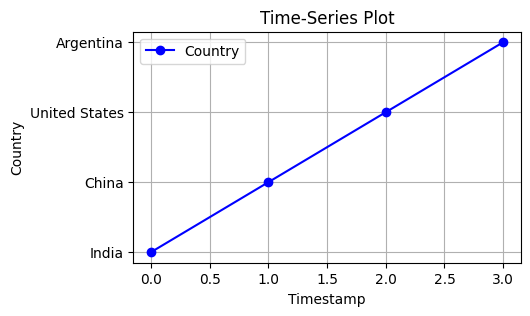

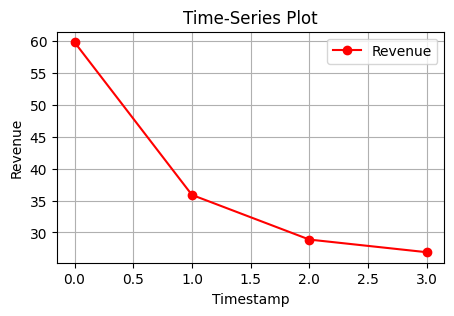

In [6]:
plt.figure(figsize=(5, 3))  

# Plot Country Against Time
plt.plot(df_country_revenue.index, df_country_revenue['country'], marker='o', linestyle='-', color='b', label='Country')

# Customize the plot
plt.title('Time-Series Plot')
plt.xlabel('Timestamp')
plt.ylabel('Country')
plt.grid(True)
plt.legend()

plt.figure(figsize=(5, 3))  # Set the figure size

# Plot Revenue Against Time
plt.plot(df_country_revenue.index, df_country_revenue['sumcountryamount'], marker='o', linestyle='-', color='r', label='Revenue')

# Customize the plot
plt.title('Time-Series Plot')
plt.xlabel('Timestamp')
plt.ylabel('Revenue')
plt.grid(True)
plt.legend()

# Display the plot
#plt.tight_layout()
plt.show()


#### Carry out a sentiment analysis on movie descriptions adding another column to the data frame that provides a sentiment classification. This can be based on a “rules based system” that you coded OR inference from a LLM such as using the API for chatgpt.

In [7]:
def detect_sentiment_1(text):
    analysis = TextBlob(text)

    print(f"Sentence: {text} Val: {analysis.sentiment.polarity}")
     
    # Sentiment polarity ranges from -1 (negative) to 1 (positive)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Input text for sentiment analysis
#input_text = [ "I love this product! It's amazing.", "I hate you", "This is a dog" ]

# Detect sentiment and print the result
#for text in input_text:
 #   sentiment = detect_sentiment(text)
  #  print(f"Sentence: {text} Sentiment: {sentiment}")

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def detect_sentiment_2(text):
    analyzer = SentimentIntensityAnalyzer()
    
    sentiment = analyzer.polarity_scores(text)

    if sentiment['compound'] > 0:
        return "Positive"
    elif sentiment['compound'] < 0:
        return "Negative"
    else:
        return "Neutral"

In [9]:


nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def detect_sentiment_3(text):
    sentiment = sia.polarity_scores(text)
    
    if sentiment['compound'] > 0:
        return "Positive"
    elif sentiment['compound'] < 0:
        return "Negative"
    else:
        return "Neutral"


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
from transformers import pipeline

def detect_sentiment_5(text):
    sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

    results = sentiment_analyzer(text)
    
    for result in results:
        label = result['label']
        score = result['score']
        print(f"Sentiment: {label}, Score: {score}")


In [11]:
positiveWords = ['abound','abounds','abundance','abundant','accessable','accessible','acclaim','acclaimed','acclamation','accolade','accolades','accommodative','accomodative','accomplish','accomplished','accomplishment','accomplishments','accurate','accurately','achievable','achievement','achievements','achievible','acumen','adaptable','adaptive','adequate','adjustable','admirable','admirably','admiration','admire','admirer','admiring','admiringly','adorable','adore','adored','adorer','adoring','adoringly','adroit','adroitly','adulate','adulation','adulatory','advanced','advantage','advantageous','advantageously','advantages','adventuresome','adventurous','advocate','advocated','advocates','affability','affable','affably','affectation','affection','affectionate','affinity','affirm','affirmation','affirmative','affluence','affluent','afford','affordable','affordably','afordable','agile','agilely','agility','agreeable','agreeableness','agreeably','all-around','alluring','alluringly','altruistic','altruistically','amaze','amazed','amazement','amazes','amazing','amazingly','ambitious','ambitiously','ameliorate','amenable','amenity','amiability','amiabily','amiable','amicability','amicable','amicably','amity','ample','amply','amuse','amusing','amusingly','angel','angelic','apotheosis','appeal','appealing','applaud','appreciable','appreciate','appreciated','appreciates','appreciative','appreciatively','appropriate','approval','approve','ardent','ardently','ardor','articulate','aspiration','aspirations','aspire','assurance','assurances','assure','assuredly','assuring','astonish','astonished','astonishing','astonishingly','astonishment','astound','astounded','astounding','astoundingly','astutely','attentive','attraction','attractive','attractively','attune','audible','audibly','auspicious','authentic','authoritative','autonomous','available','aver','avid','avidly','award','awarded','awards','awe','awed','awesome','awesomely','awesomeness','awestruck','awsome','backbone','balanced','bargain','beauteous','beautiful','beautifullly','beautifully','beautify','beauty','beckon','beckoned','beckoning','beckons','believable','believeable','beloved','benefactor','beneficent','beneficial','beneficially','beneficiary','benefit','benefits','benevolence','benevolent','benifits','best','best-known','best-performing','best-selling','better','better-known','better-than-expected','beutifully','blameless','bless','blessing','bliss','blissful','blissfully','blithe','blockbuster','bloom','blossom','bolster','bonny','bonus','bonuses','boom','booming','boost','boundless','bountiful','brainiest','brainy','brand-new','brave','bravery','bravo','breakthrough','breakthroughs','breathlessness','breathtaking','breathtakingly','breeze','bright','brighten','brighter','brightest','brilliance','brilliances','brilliant','brilliantly','brisk','brotherly','bullish','buoyant','cajole','calm','calming','calmness','capability','capable','capably','captivate','captivating','carefree','cashback','cashbacks','catchy','celebrate','celebrated','celebration','celebratory','champ','champion','charisma','charismatic','charitable','charm','charming','charmingly','chaste','cheaper','cheapest','cheer','cheerful','cheery','cherish','cherished','cherub','chic','chivalrous','chivalry','civility','civilize','clarity','classic','classy','clean','cleaner','cleanest','cleanliness','cleanly','clear','clear-cut','cleared','clearer','clearly','clears','clever','cleverly','cohere','coherence','coherent','cohesive','colorful','comely','comfort','comfortable','comfortably','comforting','comfy','commend','commendable','commendably','commitment','commodious','compact','compactly','compassion','compassionate','compatible','competitive','complement','complementary','complemented','complements','compliant','compliment','complimentary','comprehensive','conciliate','conciliatory','concise','confidence','confident','congenial','congratulate','congratulation','congratulations','congratulatory','conscientious','considerate','consistent','consistently','constructive','consummate','contentment','continuity','contrasty','contribution','convenience','convenient','conveniently','convience','convienient','convient','convincing','convincingly','cool','coolest','cooperative','cooperatively','cornerstone','correct','correctly','cost-effective','cost-saving','counter-attack','counter-attacks','courage','courageous','courageously','courageousness','courteous','courtly','covenant','cozy','creative','credence','credible','crisp','crisper','cure','cure-all','cushy','cute','cuteness','danke','danken','daring','daringly','darling','dashing','dauntless','dawn','dazzle','dazzled','dazzling','dead-cheap','dead-on','decency','decent','decisive','decisiveness','dedicated','defeat','defeated','defeating','defeats','defender','deference','deft','deginified','delectable','delicacy','delicate','delicious','delight','delighted','delightful','delightfully','delightfulness','dependable','dependably','deservedly','deserving','desirable','desiring','desirous','destiny','detachable','devout','dexterous','dexterously','dextrous','dignified','dignify','dignity','diligence','diligent','diligently','diplomatic','dirt-cheap','distinction','distinctive','distinguished','diversified','divine','divinely','dominate','dominated','dominates','dote','dotingly','doubtless','dreamland','dumbfounded','dumbfounding','dummy-proof','durable','dynamic','eager','eagerly','eagerness','earnest','earnestly','earnestness','ease','eased','eases','easier','easiest','easiness','easing','easy','easy-to-use','easygoing','ebullience','ebullient','ebulliently','ecenomical','economical','ecstasies','ecstasy','ecstatic','ecstatically','edify','educated','effective','effectively','effectiveness','effectual','efficacious','efficient','efficiently','effortless','effortlessly','effusion','effusive','effusively','effusiveness','elan','elate','elated','elatedly','elation','electrify','elegance','elegant','elegantly','elevate','elite','eloquence','eloquent','eloquently','embolden','eminence','eminent','empathize','empathy','empower','empowerment','enchant','enchanted','enchanting','enchantingly','encourage','encouragement','encouraging','encouragingly','endear','endearing','endorse','endorsed','endorsement','endorses','endorsing','energetic','energize','energy-efficient','energy-saving','engaging','engrossing','enhance','enhanced','enhancement','enhances','enjoy','enjoyable','enjoyably','enjoyed','enjoying','enjoyment','enjoys','enlighten','enlightenment','enliven','ennoble','enough','enrapt','enrapture','enraptured','enrich','enrichment','enterprising','entertain','entertaining','entertains','enthral','enthrall','enthralled','enthuse','enthusiasm','enthusiast','enthusiastic','enthusiastically','entice','enticed','enticing','enticingly','entranced','entrancing','entrust','enviable','enviably','envious','enviously','enviousness','envy','equitable','ergonomical','err-free','erudite','ethical','eulogize','euphoria','euphoric','euphorically','evaluative','evenly','eventful','everlasting','evocative','exalt','exaltation','exalted','exaltedly','exalting','exaltingly','examplar','examplary','excallent','exceed','exceeded','exceeding','exceedingly','exceeds','excel','exceled','excelent','excellant','excelled','excellence','excellency','excellent','excellently','excels','exceptional','exceptionally','excite','excited','excitedly','excitedness','excitement','excites','exciting','excitingly','exellent','exemplar','exemplary','exhilarate','exhilarating','exhilaratingly','exhilaration','exonerate','expansive','expeditiously','expertly','exquisite','exquisitely','extol','extoll','extraordinarily','extraordinary','exuberance','exuberant','exuberantly','exult','exultant','exultation','exultingly','eye-catch','eye-catching','eyecatch','eyecatching','fabulous','fabulously','facilitate','fair','fairly','fairness','faith','faithful','faithfully','faithfulness','fame','famed','famous','famously','fancier','fancinating','fancy','fanfare','fans','fantastic','fantastically','fascinate','fascinating','fascinatingly','fascination','fashionable','fashionably','fast','fast-growing','fast-paced','faster','fastest','fastest-growing','faultless','fav','fave','favor','favorable','favored','favorite','favorited','favour','fearless','fearlessly','feasible','feasibly','feat','feature-rich','fecilitous','feisty','felicitate','felicitous','felicity','fertile','fervent','fervently','fervid','fervidly','fervor','festive','fidelity','fiery','fine','fine-looking','finely','finer','finest','firmer','first-class','first-in-class','first-rate','flashy','flatter','flattering','flatteringly','flawless','flawlessly','flexibility','flexible','flourish','flourishing','fluent','flutter','fond','fondly','fondness','foolproof','foremost','foresight','formidable','fortitude','fortuitous','fortuitously','fortunate','fortunately','fortune','fragrant','free','freed','freedom','freedoms','fresh','fresher','freshest','friendliness','friendly','frolic','frugal','fruitful','ftw','fulfillment','fun','futurestic','futuristic','gaiety','gaily','gain','gained','gainful','gainfully','gaining','gains','gallant','gallantly','galore','geekier','geeky','gem','gems','generosity','generous','generously','genial','genius','gentle','gentlest','genuine','gifted','glad','gladden','gladly','gladness','glamorous','glee','gleeful','gleefully','glimmer','glimmering','glisten','glistening','glitter','glitz','glorify','glorious','gloriously','glory','glow','glowing','glowingly','god-given','god-send','godlike','godsend','gold','golden','good','goodly','goodness','goodwill','goood','gooood','gorgeous','gorgeously','grace','graceful','gracefully','gracious','graciously','graciousness','grand','grandeur','grateful','gratefully','gratification','gratified','gratifies','gratify','gratifying','gratifyingly','gratitude','great','greatest','greatness','grin','groundbreaking','guarantee','guidance','guiltless','gumption','gush','gusto','gutsy','hail','halcyon','hale','hallmark','hallmarks','hallowed','handier','handily','hands-down','handsome','handsomely','handy','happier','happily','happiness','happy','hard-working','hardier','hardy','harmless','harmonious','harmoniously','harmonize','harmony','headway','heal','healthful','healthy','hearten','heartening','heartfelt','heartily','heartwarming','heaven','heavenly','helped','helpful','helping','hero','heroic','heroically','heroine','heroize','heros','high-quality','high-spirited','hilarious','holy','homage','honest','honesty','honor','honorable','honored','honoring','hooray','hopeful','hospitable','hot','hotcake','hotcakes','hottest','hug','humane','humble','humility','humor','humorous','humorously','humour','humourous','ideal','idealize','ideally','idol','idolize','idolized','idyllic','illuminate','illuminati','illuminating','illumine','illustrious','ilu','imaculate','imaginative','immaculate','immaculately','immense','impartial','impartiality','impartially','impassioned','impeccable','impeccably','important','impress','impressed','impresses','impressive','impressively','impressiveness','improve','improved','improvement','improvements','improves','improving','incredible','incredibly','indebted','individualized','indulgence','indulgent','industrious','inestimable','inestimably','inexpensive','infallibility','infallible','infallibly','influential','ingenious','ingeniously','ingenuity','ingenuous','ingenuously','innocuous','innovation','innovative','inpressed','insightful','insightfully','inspiration','inspirational','inspire','inspiring','instantly','instructive','instrumental','integral','integrated','intelligence','intelligent','intelligible','interesting','interests','intimacy','intimate','intricate','intrigue','intriguing','intriguingly','intuitive','invaluable','invaluablely','inventive','invigorate','invigorating','invincibility','invincible','inviolable','inviolate','invulnerable','irreplaceable','irreproachable','irresistible','irresistibly','issue-free','jaw-droping','jaw-dropping','jollify','jolly','jovial','joy','joyful','joyfully','joyous','joyously','jubilant','jubilantly','jubilate','jubilation','jubiliant','judicious','justly','keen','keenly','keenness','kid-friendly','kindliness','kindly','kindness','knowledgeable','kudos','large-capacity','laud','laudable','laudably','lavish','lavishly','law-abiding','lawful','lawfully','lead','leading','leads','lean','led','legendary','leverage','levity','liberate','liberation','liberty','lifesaver','light-hearted','lighter','likable','like','liked','likes','liking','lionhearted','lively','logical','long-lasting','lovable','lovably','love','loved','loveliness','lovely','lover','loves','loving','low-cost','low-price','low-priced','low-risk','lower-priced','loyal','loyalty','lucid','lucidly','luck','luckier','luckiest','luckiness','lucky','lucrative','luminous','lush','luster','lustrous','luxuriant','luxuriate','luxurious','luxuriously','luxury','lyrical','magic','magical','magnanimous','magnanimously','magnificence','magnificent','magnificently','majestic','majesty','manageable','maneuverable','marvel','marveled','marvelled','marvellous','marvelous','marvelously','marvelousness','marvels','master','masterful','masterfully','masterpiece','masterpieces','masters','mastery','matchless','mature','maturely','maturity','meaningful','memorable','merciful','mercifully','mercy','merit','meritorious','merrily','merriment','merriness','merry','mesmerize','mesmerized','mesmerizes','mesmerizing','mesmerizingly','meticulous','meticulously','mightily','mighty','mind-blowing','miracle','miracles','miraculous','miraculously','miraculousness','modern','modest','modesty','momentous','monumental','monumentally','morality','motivated','multi-purpose','navigable','neat','neatest','neatly','nice','nicely','nicer','nicest','nifty','nimble','noble','nobly','noiseless','non-violence','non-violent','notably','noteworthy','nourish','nourishing','nourishment','novelty','nurturing','oasis','obsession','obsessions','obtainable','openly','openness','optimal','optimism','optimistic','opulent','orderly','originality','outdo','outdone','outperform','outperformed','outperforming','outperforms','outshine','outshone','outsmart','outstanding','outstandingly','outstrip','outwit','ovation','overjoyed','overtake','overtaken','overtakes','overtaking','overtook','overture','pain-free','painless','painlessly','palatial','pamper','pampered','pamperedly','pamperedness','pampers','panoramic','paradise','paramount','pardon','passion','passionate','passionately','patience','patient','patiently','patriot','patriotic','peace','peaceable','peaceful','peacefully','peacekeepers','peach','peerless','pep','pepped','pepping','peppy','peps','perfect','perfection','perfectly','permissible','perseverance','persevere','personages','personalized','phenomenal','phenomenally','picturesque','piety','pinnacle','playful','playfully','pleasant','pleasantly','pleased','pleases','pleasing','pleasingly','pleasurable','pleasurably','pleasure','plentiful','pluses','plush','plusses','poetic','poeticize','poignant','poise','poised','polished','polite','politeness','popular','portable','posh','positive','positively','positives','powerful','powerfully','praise','praiseworthy','praising','pre-eminent','precious','precise','precisely','preeminent','prefer','preferable','preferably','prefered','preferes','preferring','prefers','premier','prestige','prestigious','prettily','pretty','priceless','pride','principled','privilege','privileged','prize','proactive','problem-free','problem-solver','prodigious','prodigiously','prodigy','productive','productively','proficient','proficiently','profound','profoundly','profuse','profusion','progress','progressive','prolific','prominence','prominent','promise','promised','promises','promising','promoter','prompt','promptly','proper','properly','propitious','propitiously','pros','prosper','prosperity','prosperous','prospros','protect','protection','protective','proud','proven','proves','providence','proving','prowess','prudence','prudent','prudently','punctual','pure','purify','purposeful','quaint','qualified','qualify','quicker','quiet','quieter','radiance','radiant','rapid','rapport','rapt','rapture','raptureous','raptureously','rapturous','rapturously','rational','razor-sharp','reachable','readable','readily','ready','reaffirm','reaffirmation','realistic','realizable','reasonable','reasonably','reasoned','reassurance','reassure','receptive','reclaim','recomend','recommend','recommendation','recommendations','recommended','reconcile','reconciliation','record-setting','recover','recovery','rectification','rectify','rectifying','redeem','redeeming','redemption','refine','refined','refinement','reform','reformed','reforming','reforms','refresh','refreshed','refreshing','refund','refunded','regal','regally','regard','rejoice','rejoicing','rejoicingly','rejuvenate','rejuvenated','rejuvenating','relaxed','relent','reliable','reliably','relief','relish','remarkable','remarkably','remedy','remission','remunerate','renaissance','renewed','renown','renowned','replaceable','reputable','reputation','resilient','resolute','resound','resounding','resourceful','resourcefulness','respect','respectable','respectful','respectfully','respite','resplendent','responsibly','responsive','restful','restored','restructure','restructured','restructuring','retractable','revel','revelation','revere','reverence','reverent','reverently','revitalize','revival','revive','revives','revolutionary','revolutionize','revolutionized','revolutionizes','reward','rewarding','rewardingly','rich','richer','richly','richness','right','righten','righteous','righteously','righteousness','rightful','rightfully','rightly','rightness','risk-free','robust','rock-star','rock-stars','rockstar','rockstars','romantic','romantically','romanticize','roomier','roomy','rosy','safe','safely','sagacity','sagely','saint','saintliness','saintly','salutary','salute','sane','satisfactorily','satisfactory','satisfied','satisfies','satisfy','satisfying','satisified','saver','savings','savior','savvy','scenic','seamless','seasoned','secure','securely','selective','self-determination','self-respect','self-satisfaction','self-sufficiency','self-sufficient','sensation','sensational','sensationally','sensations','sensible','sensibly','sensitive','serene','serenity','sexy','sharp','sharper','sharpest','shimmering','shimmeringly','shine','shiny','significant','silent','simpler','simplest','simplified','simplifies','simplify','simplifying','sincere','sincerely','sincerity','skill','skilled','skillful','skillfully','slammin','sleek','slick','smart','smarter','smartest','smartly','smile','smiles','smiling','smilingly','smitten','smooth','smoother','smoothes','smoothest','smoothly','snappy','snazzy','sociable','soft','softer','solace','solicitous','solicitously','solid','solidarity','soothe','soothingly','sophisticated','soulful','soundly','soundness','spacious','sparkle','sparkling','spectacular','spectacularly','speedily','speedy','spellbind','spellbinding','spellbindingly','spellbound','spirited','spiritual','splendid','splendidly','splendor','spontaneous','sporty','spotless','sprightly','stability','stabilize','stable','stainless','standout','state-of-the-art','stately','statuesque','staunch','staunchly','staunchness','steadfast','steadfastly','steadfastness','steadiest','steadiness','steady','stellar','stellarly','stimulate','stimulates','stimulating','stimulative','stirringly','straighten','straightforward','streamlined','striking','strikingly','striving','strong','stronger','strongest','stunned','stunning','stunningly','stupendous','stupendously','sturdier','sturdy','stylish','stylishly','stylized','suave','suavely','sublime','subsidize','subsidized','subsidizes','subsidizing','substantive','succeed','succeeded','succeeding','succeeds','succes','success','successes','successful','successfully','suffice','sufficed','suffices','sufficient','sufficiently','suitable','sumptuous','sumptuously','sumptuousness','super','superb','superbly','superior','superiority','supple','support','supported','supporter','supporting','supportive','supports','supremacy','supreme','supremely','supurb','supurbly','surmount','surpass','surreal','survival','survivor','sustainability','sustainable','swank','swankier','swankiest','swanky','sweeping','sweet','sweeten','sweetheart','sweetly','sweetness','swift','swiftness','talent','talented','talents','tantalize','tantalizing','tantalizingly','tempt','tempting','temptingly','tenacious','tenaciously','tenacity','tender','tenderly','terrific','terrifically','thank','thankful','thinner','thoughtful','thoughtfully','thoughtfulness','thrift','thrifty','thrill','thrilled','thrilling','thrillingly','thrills','thrive','thriving','thumb-up','thumbs-up','tickle','tidy','time-honored','timely','tingle','titillate','titillating','titillatingly','togetherness','tolerable','toll-free','top','top-notch','top-quality','topnotch','tops','tough','tougher','toughest','traction','tranquil','tranquility','transparent','treasure','tremendously','trendy','triumph','triumphal','triumphant','triumphantly','trivially','trophy','trouble-free','trump','trumpet','trust','trusted','trusting','trustingly','trustworthiness','trustworthy','trusty','truthful','truthfully','truthfulness','twinkly','ultra-crisp','unabashed','unabashedly','unaffected','unassailable','unbeatable','unbiased','unbound','uncomplicated','unconditional','undamaged','undaunted','understandable','undisputable','undisputably','undisputed','unencumbered','unequivocal','unequivocally','unfazed','unfettered','unforgettable','unity','unlimited','unmatched','unparalleled','unquestionable','unquestionably','unreal','unrestricted','unrivaled','unselfish','unwavering','upbeat','upgradable','upgradeable','upgraded','upheld','uphold','uplift','uplifting','upliftingly','upliftment','upscale','usable','useable','useful','user-friendly','user-replaceable','valiant','valiantly','valor','valuable','variety','venerate','verifiable','veritable','versatile','versatility','vibrant','vibrantly','victorious','victory','viewable','vigilance','vigilant','virtue','virtuous','virtuously','visionary','vivacious','vivid','vouch','vouchsafe','warm','warmer','warmhearted','warmly','warmth','wealthy','welcome','well','well-backlit','well-balanced','well-behaved','well-being','well-bred','well-connected','well-educated','well-established','well-informed','well-intentioned','well-known','well-made','well-managed','well-mannered','well-positioned','well-received','well-regarded','well-rounded','well-run','well-wishers','wellbeing','whoa','wholeheartedly','wholesome','whooa','whoooa','wieldy','willing','willingly','willingness','win','windfall','winnable','winner','winners','winning','wins','wisdom','wise','wisely','witty','won','wonder','wonderful','wonderfully','wonderous','wonderously','wonders','wondrous','woo','work','workable','worked','works','world-famous','worth','worth-while','worthiness','worthwhile','worthy','wow','wowed','wowing','wows','yay','youthful','zeal','zenith','zest','zippy'] 
negativeWords = ['2-faced','2-faces','abnormal','abolish','abominable','abominably','abominate','abomination','abort','aborted','aborts','abrade','abrasive','abrupt','abruptly','abscond','absence','absent-minded','absentee','absurd','absurdity','absurdly','absurdness','abuse','abused','abuses','abusive','abysmal','abysmally','abyss','accidental','accost','accursed','accusation','accusations','accuse','accuses','accusing','accusingly','acerbate','acerbic','acerbically','ache','ached','aches','achey','aching','acrid','acridly','acridness','acrimonious','acrimoniously','acrimony','adamant','adamantly','addict','addicted','addicting','addicts','admonish','admonisher','admonishingly','admonishment','admonition','adulterate','adulterated','adulteration','adulterier','adversarial','adversary','adverse','adversity','afflict','affliction','afflictive','affront','afraid','aggravate','aggravating','aggravation','aggression','aggressive','aggressiveness','aggressor','aggrieve','aggrieved','aggrivation','aghast','agonies','agonize','agonizing','agonizingly','agony','aground','ail','ailing','ailment','aimless','alarm','alarmed','alarming','alarmingly','alienate','alienated','alienation','allegation','allegations','allege','allergic','allergies','allergy','aloof','altercation','ambiguity','ambiguous','ambivalence','ambivalent','ambush','amiss','amputate','anarchism','anarchist','anarchistic','anarchy','anemic','anger','angrily','angriness','angry','anguish','animosity','annihilate','annihilation','annoy','annoyance','annoyances','annoyed','annoying','annoyingly','annoys','anomalous','anomaly','antagonism','antagonist','antagonistic','antagonize','anti-','anti-american','anti-israeli','anti-occupation','anti-proliferation','anti-semites','anti-social','anti-us','anti-white','antipathy','antiquated','antithetical','anxieties','anxiety','anxious','anxiously','anxiousness','apathetic','apathetically','apathy','apocalypse','apocalyptic','apologist','apologists','appal','appall','appalled','appalling','appallingly','apprehension','apprehensions','apprehensive','apprehensively','arbitrary','arcane','archaic','arduous','arduously','argumentative','arrogance','arrogant','arrogantly','ashamed','asinine','asininely','asinininity','askance','asperse','aspersion','aspersions','assail','assassin','assassinate','assault','assult','astray','asunder','atrocious','atrocities','atrocity','atrophy','attack','attacks','audacious','audaciously','audaciousness','audacity','audiciously','austere','authoritarian','autocrat','autocratic','avalanche','avarice','avaricious','avariciously','avenge','averse','aversion','aweful','awful','awfully','awfulness','awkward','awkwardness','ax','babble','back-logged','back-wood','back-woods','backache','backaches','backaching','backbite','backbiting','backward','backwardness','backwood','backwoods','bad','badly','baffle','baffled','bafflement','baffling','bait','balk','banal','banalize','bane','banish','banishment','bankrupt','barbarian','barbaric','barbarically','barbarity','barbarous','barbarously','barren','baseless','bash','bashed','bashful','bashing','bastard','bastards','battered','battering','batty','bearish','beastly','bedlam','bedlamite','befoul','beg','beggar','beggarly','begging','beguile','belabor','belated','beleaguer','belie','belittle','belittled','belittling','bellicose','belligerence','belligerent','belligerently','bemoan','bemoaning','bemused','bent','berate','bereave','bereavement','bereft','berserk','beseech','beset','besiege','besmirch','bestial','betray','betrayal','betrayals','betrayer','betraying','betrays','bewail','beware','bewilder','bewildered','bewildering','bewilderingly','bewilderment','bewitch','bias','biased','biases','bicker','bickering','bid-rigging','bigotries','bigotry','bitch','bitchy','biting','bitingly','bitter','bitterly','bitterness','bizarre','blab','blabber','blackmail','blah','blame','blameworthy','bland','blandish','blaspheme','blasphemous','blasphemy','blasted','blatant','blatantly','blather','bleak','bleakly','bleakness','bleed','bleeding','bleeds','blemish','blind','blinding','blindingly','blindside','blister','blistering','bloated','blockage','blockhead','bloodshed','bloodthirsty','bloody','blotchy','blow','blunder','blundering','blunders','blunt','blur','bluring','blurred','blurring','blurry','blurs','blurt','boastful','boggle','bogus','boil','boiling','boisterous','bomb','bombard','bombardment','bombastic','bondage','bonkers','bore','bored','boredom','bores','boring','botch','bother','bothered','bothering','bothers','bothersome','bowdlerize','boycott','braggart','bragger','brainless','brainwash','brash','brashly','brashness','brat','bravado','brazen','brazenly','brazenness','breach','break','break-up','break-ups','breakdown','breaking','breaks','breakup','breakups','bribery','brimstone','bristle','brittle','broke','broken','broken-hearted','brood','browbeat','bruise','bruised','bruises','bruising','brusque','brutal','brutalising','brutalities','brutality','brutalize','brutalizing','brutally','brute','brutish','bs','buckle','bug','bugging','buggy','bugs','bulkier','bulkiness','bulky','bulkyness','bull****','bull----','bullies','bullshit','bullshyt','bully','bullying','bullyingly','bum','bump','bumped','bumping','bumpping','bumps','bumpy','bungle','bungler','bungling','bunk','burden','burdensome','burdensomely','burn','burned','burning','burns','bust','busts','busybody','butcher','butchery','buzzing','byzantine','cackle','calamities','calamitous','calamitously','calamity','callous','calumniate','calumniation','calumnies','calumnious','calumniously','calumny','cancer','cancerous','cannibal','cannibalize','capitulate','capricious','capriciously','capriciousness','capsize','careless','carelessness','caricature','carnage','carp','cartoonish','cash-strapped','castigate','castrated','casualty','cataclysm','cataclysmal','cataclysmic','cataclysmically','catastrophe','catastrophes','catastrophic','catastrophically','catastrophies','caustic','caustically','cautionary','cave','censure','chafe','chaff','chagrin','challenging','chaos','chaotic','chasten','chastise','chastisement','chatter','chatterbox','cheap','cheapen','cheaply','cheat','cheated','cheater','cheating','cheats','checkered','cheerless','cheesy','chide','childish','chill','chilly','chintzy','choke','choleric','choppy','chore','chronic','chunky','clamor','clamorous','clash','cliche','cliched','clique','clog','clogged','clogs','cloud','clouding','cloudy','clueless','clumsy','clunky','coarse','cocky','coerce','coercion','coercive','cold','coldly','collapse','collude','collusion','combative','combust','comical','commiserate','commonplace','commotion','commotions','complacent','complain','complained','complaining','complains','complaint','complaints','complex','complicated','complication','complicit','compulsion','compulsive','concede','conceded','conceit','conceited','concen','concens','concern','concerned','concerns','concession','concessions','condemn','condemnable','condemnation','condemned','condemns','condescend','condescending','condescendingly','condescension','confess','confession','confessions','confined','conflict','conflicted','conflicting','conflicts','confound','confounded','confounding','confront','confrontation','confrontational','confuse','confused','confuses','confusing','confusion','confusions','congested','congestion','cons','conscons','conservative','conspicuous','conspicuously','conspiracies','conspiracy','conspirator','conspiratorial','conspire','consternation','contagious','contaminate','contaminated','contaminates','contaminating','contamination','contempt','contemptible','contemptuous','contemptuously','contend','contention','contentious','contort','contortions','contradict','contradiction','contradictory','contrariness','contravene','contrive','contrived','controversial','controversy','convoluted','corrode','corrosion','corrosions','corrosive','corrupt','corrupted','corrupting','corruption','corrupts','corruptted','costlier','costly','counter-productive','counterproductive','coupists','covetous','coward','cowardly','crabby','crack','cracked','cracks','craftily','craftly','crafty','cramp','cramped','cramping','cranky','crap','crappy','craps','crash','crashed','crashes','crashing','crass','craven','cravenly','craze','crazily','craziness','crazy','creak','creaking','creaks','credulous','creep','creeping','creeps','creepy','crept','crime','criminal','cringe','cringed','cringes','cripple','crippled','cripples','crippling','crisis','critic','critical','criticism','criticisms','criticize','criticized','criticizing','critics','cronyism','crook','crooked','crooks','crowded','crowdedness','crude','cruel','crueler','cruelest','cruelly','cruelness','cruelties','cruelty','crumble','crumbling','crummy','crumple','crumpled','crumples','crush','crushed','crushing','cry','culpable','culprit','cumbersome','cunt','cunts','cuplrit','curse','cursed','curses','curt','cuss','cussed','cutthroat','cynical','cynicism','d*mn','damage','damaged','damages','damaging','damn','damnable','damnably','damnation','damned','damning','damper','danger','dangerous','dangerousness','dark','darken','darkened','darker','darkness','dastard','dastardly','daunt','daunting','dauntingly','dawdle','daze','dazed','dead','deadbeat','deadlock','deadly','deadweight','deaf','dearth','death','debacle','debase','debasement','debaser','debatable','debauch','debaucher','debauchery','debilitate','debilitating','debility','debt','debts','decadence','decadent','decay','decayed','deceit','deceitful','deceitfully','deceitfulness','deceive','deceiver','deceivers','deceiving','deception','deceptive','deceptively','declaim','decline','declines','declining','decrement','decrepit','decrepitude','decry','defamation','defamations','defamatory','defame','defect','defective','defects','defensive','defiance','defiant','defiantly','deficiencies','deficiency','deficient','defile','defiler','deform','deformed','defrauding','defunct','defy','degenerate','degenerately','degeneration','degradation','degrade','degrading','degradingly','dehumanization','dehumanize','deign','deject','dejected','dejectedly','dejection','delay','delayed','delaying','delays','delinquency','delinquent','delirious','delirium','delude','deluded','deluge','delusion','delusional','delusions','demean','demeaning','demise','demolish','demolisher','demon','demonic','demonize','demonized','demonizes','demonizing','demoralize','demoralizing','demoralizingly','denial','denied','denies','denigrate','denounce','dense','dent','dented','dents','denunciate','denunciation','denunciations','deny','denying','deplete','deplorable','deplorably','deplore','deploring','deploringly','deprave','depraved','depravedly','deprecate','depress','depressed','depressing','depressingly','depression','depressions','deprive','deprived','deride','derision','derisive','derisively','derisiveness','derogatory','desecrate','desert','desertion','desiccate','desiccated','desititute','desolate','desolately','desolation','despair','despairing','despairingly','desperate','desperately','desperation','despicable','despicably','despise','despised','despoil','despoiler','despondence','despondency','despondent','despondently','despot','despotic','despotism','destabilisation','destains','destitute','destitution','destroy','destroyer','destruction','destructive','desultory','deter','deteriorate','deteriorating','deterioration','deterrent','detest','detestable','detestably','detested','detesting','detests','detract','detracted','detracting','detraction','detracts','detriment','detrimental','devastate','devastated','devastates','devastating','devastatingly','devastation','deviate','deviation','devil','devilish','devilishly','devilment','devilry','devious','deviously','deviousness','devoid','diabolic','diabolical','diabolically','diametrically','diappointed','diatribe','diatribes','dick','dictator','dictatorial','die','die-hard','died','dies','difficult','difficulties','difficulty','diffidence','dilapidated','dilemma','dilly-dally','dim','dimmer','din','ding','dings','dinky','dire','direly','direness','dirt','dirtbag','dirtbags','dirts','dirty','disable','disabled','disaccord','disadvantage','disadvantaged','disadvantageous','disadvantages','disaffect','disaffected','disaffirm','disagree','disagreeable','disagreeably','disagreed','disagreeing','disagreement','disagrees','disallow','disapointed','disapointing','disapointment','disappoint','disappointed','disappointing','disappointingly','disappointment','disappointments','disappoints','disapprobation','disapproval','disapprove','disapproving','disarm','disarray','disaster','disasterous','disastrous','disastrously','disavow','disavowal','disbelief','disbelieve','disbeliever','disclaim','discombobulate','discomfit','discomfititure','discomfort','discompose','disconcert','disconcerted','disconcerting','disconcertingly','disconsolate','disconsolately','disconsolation','discontent','discontented','discontentedly','discontinued','discontinuity','discontinuous','discord','discordance','discordant','discountenance','discourage','discouragement','discouraging','discouragingly','discourteous','discourteously','discoutinous','discredit','discrepant','discriminate','discrimination','discriminatory','disdain','disdained','disdainful','disdainfully','disfavor','disgrace','disgraced','disgraceful','disgracefully','disgruntle','disgruntled','disgust','disgusted','disgustedly','disgustful','disgustfully','disgusting','disgustingly','dishearten','disheartening','dishearteningly','dishonest','dishonestly','dishonesty','dishonor','dishonorable','dishonorablely','disillusion','disillusioned','disillusionment','disillusions','disinclination','disinclined','disingenuous','disingenuously','disintegrate','disintegrated','disintegrates','disintegration','disinterest','disinterested','dislike','disliked','dislikes','disliking','dislocated','disloyal','disloyalty','dismal','dismally','dismalness','dismay','dismayed','dismaying','dismayingly','dismissive','dismissively','disobedience','disobedient','disobey','disoobedient','disorder','disordered','disorderly','disorganized','disorient','disoriented','disown','disparage','disparaging','disparagingly','dispensable','dispirit','dispirited','dispiritedly','dispiriting','displace','displaced','displease','displeased','displeasing','displeasure','disproportionate','disprove','disputable','dispute','disputed','disquiet','disquieting','disquietingly','disquietude','disregard','disregardful','disreputable','disrepute','disrespect','disrespectable','disrespectablity','disrespectful','disrespectfully','disrespectfulness','disrespecting','disrupt','disruption','disruptive','diss','dissapointed','dissappointed','dissappointing','dissatisfaction','dissatisfactory','dissatisfied','dissatisfies','dissatisfy','dissatisfying','dissed','dissemble','dissembler','dissension','dissent','dissenter','dissention','disservice','disses','dissidence','dissident','dissidents','dissing','dissocial','dissolute','dissolution','dissonance','dissonant','dissonantly','dissuade','dissuasive','distains','distaste','distasteful','distastefully','distort','distorted','distortion','distorts','distract','distracting','distraction','distraught','distraughtly','distraughtness','distress','distressed','distressing','distressingly','distrust','distrustful','distrusting','disturb','disturbance','disturbed','disturbing','disturbingly','disunity','disvalue','divergent','divisive','divisively','divisiveness','dizzing','dizzingly','dizzy','doddering','dodgey','dogged','doggedly','dogmatic','doldrums','domineer','domineering','donside','doom','doomed','doomsday','dope','doubt','doubtful','doubtfully','doubts','douchbag','douchebag','douchebags','downbeat','downcast','downer','downfall','downfallen','downgrade','downhearted','downheartedly','downhill','downside','downsides','downturn','downturns','drab','draconian','draconic','drag','dragged','dragging','dragoon','drags','drain','drained','draining','drains','drastic','drastically','drawback','drawbacks','dread','dreadful','dreadfully','dreadfulness','dreary','dripped','dripping','drippy','drips','drones','droop','droops','drop-out','drop-outs','dropout','dropouts','drought','drowning','drunk','drunkard','drunken','dubious','dubiously','dubitable','dud','dull','dullard','dumb','dumbfound','dump','dumped','dumping','dumps','dunce','dungeon','dungeons','dupe','dust','dusty','dwindling','dying','earsplitting','eccentric','eccentricity','effigy','effrontery','egocentric','egomania','egotism','egotistical','egotistically','egregious','egregiously','election-rigger','elimination','emaciated','emasculate','embarrass','embarrassing','embarrassingly','embarrassment','embattled','embroil','embroiled','embroilment','emergency','emphatic','emphatically','emptiness','encroach','encroachment','endanger','enemies','enemy','enervate','enfeeble','enflame','engulf','enjoin','enmity','enrage','enraged','enraging','enslave','entangle','entanglement','entrap','entrapment','envious','enviously','enviousness','epidemic','equivocal','erase','erode','erodes','erosion','err','errant','erratic','erratically','erroneous','erroneously','error','errors','eruptions','escapade','eschew','estranged','evade','evasion','evasive','evil','evildoer','evils','eviscerate','exacerbate','exagerate','exagerated','exagerates','exaggerate','exaggeration','exasperate','exasperated','exasperating','exasperatingly','exasperation','excessive','excessively','exclusion','excoriate','excruciating','excruciatingly','excuse','excuses','execrate','exhaust','exhausted','exhaustion','exhausts','exhorbitant','exhort','exile','exorbitant','exorbitantance','exorbitantly','expel','expensive','expire','expired','explode','exploit','exploitation','explosive','expropriate','expropriation','expulse','expunge','exterminate','extermination','extinguish','extort','extortion','extraneous','extravagance','extravagant','extravagantly','extremism','extremist','extremists','eyesore','f**k','fabricate','fabrication','facetious','facetiously','fail','failed','failing','fails','failure','failures','faint','fainthearted','faithless','fake','fall','fallacies','fallacious','fallaciously','fallaciousness','fallacy','fallen','falling','fallout','falls','false','falsehood','falsely','falsify','falter','faltered','famine','famished','fanatic','fanatical','fanatically','fanaticism','fanatics','fanciful','far-fetched','farce','farcical','farcical-yet-provocative','farcically','farfetched','fascism','fascist','fastidious','fastidiously','fastuous','fat','fat-cat','fat-cats','fatal','fatalistic','fatalistically','fatally','fatcat','fatcats','fateful','fatefully','fathomless','fatigue','fatigued','fatique','fatty','fatuity','fatuous','fatuously','fault','faults','faulty','fawningly','faze','fear','fearful','fearfully','fears','fearsome','feckless','feeble','feeblely','feebleminded','feign','feint','fell','felon','felonious','ferociously','ferocity','fetid','fever','feverish','fevers','fiasco','fib','fibber','fickle','fiction','fictional','fictitious','fidget','fidgety','fiend','fiendish','fierce','figurehead','filth','filthy','finagle','finicky','fissures','fist','flabbergast','flabbergasted','flagging','flagrant','flagrantly','flair','flairs','flak','flake','flakey','flakieness','flaking','flaky','flare','flares','flareup','flareups','flat-out','flaunt','flaw','flawed','flaws','flee','fleed','fleeing','fleer','flees','fleeting','flicering','flicker','flickering','flickers','flighty','flimflam','flimsy','flirt','flirty','floored','flounder','floundering','flout','fluster','foe','fool','fooled','foolhardy','foolish','foolishly','foolishness','forbid','forbidden','forbidding','forceful','foreboding','forebodingly','forfeit','forged','forgetful','forgetfully','forgetfulness','forlorn','forlornly','forsake','forsaken','forswear','foul','foully','foulness','fractious','fractiously','fracture','fragile','fragmented','frail','frantic','frantically','franticly','fraud','fraudulent','fraught','frazzle','frazzled','freak','freaking','freakish','freakishly','freaks','freeze','freezes','freezing','frenetic','frenetically','frenzied','frenzy','fret','fretful','frets','friction','frictions','fried','friggin','frigging','fright','frighten','frightening','frighteningly','frightful','frightfully','frigid','frost','frown','froze','frozen','fruitless','fruitlessly','frustrate','frustrated','frustrates','frustrating','frustratingly','frustration','frustrations','fuck','fucking','fudge','fugitive','full-blown','fulminate','fumble','fume','fumes','fundamentalism','funky','funnily','funny','furious','furiously','furor','fury','fuss','fussy','fustigate','fusty','futile','futilely','futility','fuzzy','gabble','gaff','gaffe','gainsay','gainsayer','gall','galling','gallingly','galls','gangster','gape','garbage','garish','gasp','gauche','gaudy','gawk','gawky','geezer','genocide','get-rich','ghastly','ghetto','ghosting','gibber','gibberish','gibe','giddy','gimmick','gimmicked','gimmicking','gimmicks','gimmicky','glare','glaringly','glib','glibly','glitch','glitches','gloatingly','gloom','gloomy','glower','glum','glut','gnawing','goad','goading','god-awful','goof','goofy','goon','gossip','graceless','gracelessly','graft','grainy','grapple','grate','grating','gravely','greasy','greed','greedy','grief','grievance','grievances','grieve','grieving','grievous','grievously','grim','grimace','grind','gripe','gripes','grisly','gritty','gross','grossly','grotesque','grouch','grouchy','groundless','grouse','growl','grudge','grudges','grudging','grudgingly','gruesome','gruesomely','gruff','grumble','grumpier','grumpiest','grumpily','grumpish','grumpy','guile','guilt','guiltily','guilty','gullible','gutless','gutter','hack','hacks','haggard','haggle','hairloss','halfhearted','halfheartedly','hallucinate','hallucination','hamper','hampered','handicapped','hang','hangs','haphazard','hapless','harangue','harass','harassed','harasses','harassment','harboring','harbors','hard','hard-hit','hard-line','hard-liner','hardball','harden','hardened','hardheaded','hardhearted','hardliner','hardliners','hardship','hardships','harm','harmed','harmful','harms','harpy','harridan','harried','harrow','harsh','harshly','hasseling','hassle','hassled','hassles','haste','hastily','hasty','hate','hated','hateful','hatefully','hatefulness','hater','haters','hates','hating','hatred','haughtily','haughty','haunt','haunting','havoc','hawkish','haywire','hazard','hazardous','haze','hazy','head-aches','headache','headaches','heartbreaker','heartbreaking','heartbreakingly','heartless','heathen','heavy-handed','heavyhearted','heck','heckle','heckled','heckles','hectic','hedge','hedonistic','heedless','hefty','hegemonism','hegemonistic','hegemony','heinous','hell','hell-bent','hellion','hells','helpless','helplessly','helplessness','heresy','heretic','heretical','hesitant','hestitant','hideous','hideously','hideousness','high-priced','hiliarious','hinder','hindrance','hiss','hissed','hissing','ho-hum','hoard','hoax','hobble','hogs','hollow','hoodium','hoodwink','hooligan','hopeless','hopelessly','hopelessness','horde','horrendous','horrendously','horrible','horrid','horrific','horrified','horrifies','horrify','horrifying','horrifys','hostage','hostile','hostilities','hostility','hotbeds','hothead','hotheaded','hothouse','hubris','huckster','hum','humid','humiliate','humiliating','humiliation','humming','hung','hurt','hurted','hurtful','hurting','hurts','hustler','hype','hypocricy','hypocrisy','hypocrite','hypocrites','hypocritical','hypocritically','hysteria','hysteric','hysterical','hysterically','hysterics','idiocies','idiocy','idiot','idiotic','idiotically','idiots','idle','ignoble','ignominious','ignominiously','ignominy','ignorance','ignorant','ignore','ill-advised','ill-conceived','ill-defined','ill-designed','ill-fated','ill-favored','ill-formed','ill-mannered','ill-natured','ill-sorted','ill-tempered','ill-treated','ill-treatment','ill-usage','ill-used','illegal','illegally','illegitimate','illicit','illiterate','illness','illogic','illogical','illogically','illusion','illusions','illusory','imaginary','imbalance','imbecile','imbroglio','immaterial','immature','imminence','imminently','immobilized','immoderate','immoderately','immodest','immoral','immorality','immorally','immovable','impair','impaired','impasse','impatience','impatient','impatiently','impeach','impedance','impede','impediment','impending','impenitent','imperfect','imperfection','imperfections','imperfectly','imperialist','imperil','imperious','imperiously','impermissible','impersonal','impertinent','impetuous','impetuously','impiety','impinge','impious','implacable','implausible','implausibly','implicate','implication','implode','impolite','impolitely','impolitic','importunate','importune','impose','imposers','imposing','imposition','impossible','impossiblity','impossibly','impotent','impoverish','impoverished','impractical','imprecate','imprecise','imprecisely','imprecision','imprison','imprisonment','improbability','improbable','improbably','improper','improperly','impropriety','imprudence','imprudent','impudence','impudent','impudently','impugn','impulsive','impulsively','impunity','impure','impurity','inability','inaccuracies','inaccuracy','inaccurate','inaccurately','inaction','inactive','inadequacy','inadequate','inadequately','inadverent','inadverently','inadvisable','inadvisably','inane','inanely','inappropriate','inappropriately','inapt','inaptitude','inarticulate','inattentive','inaudible','incapable','incapably','incautious','incendiary','incense','incessant','incessantly','incite','incitement','incivility','inclement','incognizant','incoherence','incoherent','incoherently','incommensurate','incomparable','incomparably','incompatability','incompatibility','incompatible','incompetence','incompetent','incompetently','incomplete','incompliant','incomprehensible','incomprehension','inconceivable','inconceivably','incongruous','incongruously','inconsequent','inconsequential','inconsequentially','inconsequently','inconsiderate','inconsiderately','inconsistence','inconsistencies','inconsistency','inconsistent','inconsolable','inconsolably','inconstant','inconvenience','inconveniently','incorrect','incorrectly','incorrigible','incorrigibly','incredulous','incredulously','inculcate','indecency','indecent','indecently','indecision','indecisive','indecisively','indecorum','indefensible','indelicate','indeterminable','indeterminably','indeterminate','indifference','indifferent','indigent','indignant','indignantly','indignation','indignity','indiscernible','indiscreet','indiscreetly','indiscretion','indiscriminate','indiscriminately','indiscriminating','indistinguishable','indoctrinate','indoctrination','indolent','indulge','ineffective','ineffectively','ineffectiveness','ineffectual','ineffectually','ineffectualness','inefficacious','inefficacy','inefficiency','inefficient','inefficiently','inelegance','inelegant','ineligible','ineloquent','ineloquently','inept','ineptitude','ineptly','inequalities','inequality','inequitable','inequitably','inequities','inescapable','inescapably','inessential','inevitable','inevitably','inexcusable','inexcusably','inexorable','inexorably','inexperience','inexperienced','inexpert','inexpertly','inexpiable','inexplainable','inextricable','inextricably','infamous','infamously','infamy','infected','infection','infections','inferior','inferiority','infernal','infest','infested','infidel','infidels','infiltrator','infiltrators','infirm','inflame','inflammation','inflammatory','inflammed','inflated','inflationary','inflexible','inflict','infraction','infringe','infringement','infringements','infuriate','infuriated','infuriating','infuriatingly','inglorious','ingrate','ingratitude','inhibit','inhibition','inhospitable','inhospitality','inhuman','inhumane','inhumanity','inimical','inimically','iniquitous','iniquity','injudicious','injure','injurious','injury','injustice','injustices','innuendo','inoperable','inopportune','inordinate','inordinately','insane','insanely','insanity','insatiable','insecure','insecurity','insensible','insensitive','insensitively','insensitivity','insidious','insidiously','insignificance','insignificant','insignificantly','insincere','insincerely','insincerity','insinuate','insinuating','insinuation','insociable','insolence','insolent','insolently','insolvent','insouciance','instability','instable','instigate','instigator','instigators','insubordinate','insubstantial','insubstantially','insufferable','insufferably','insufficiency','insufficient','insufficiently','insular','insult','insulted','insulting','insultingly','insults','insupportable','insupportably','insurmountable','insurmountably','insurrection','intefere','inteferes','intense','interfere','interference','interferes','intermittent','interrupt','interruption','interruptions','intimidate','intimidating','intimidatingly','intimidation','intolerable','intolerablely','intolerance','intoxicate','intractable','intransigence','intransigent','intrude','intrusion','intrusive','inundate','inundated','invader','invalid','invalidate','invalidity','invasive','invective','inveigle','invidious','invidiously','invidiousness','invisible','involuntarily','involuntary','irascible','irate','irately','ire','irk','irked','irking','irks','irksome','irksomely','irksomeness','irksomenesses','ironic','ironical','ironically','ironies','irony','irragularity','irrational','irrationalities','irrationality','irrationally','irrationals','irreconcilable','irrecoverable','irrecoverableness','irrecoverablenesses','irrecoverably','irredeemable','irredeemably','irreformable','irregular','irregularity','irrelevance','irrelevant','irreparable','irreplacible','irrepressible','irresolute','irresolvable','irresponsible','irresponsibly','irretating','irretrievable','irreversible','irritable','irritably','irritant','irritate','irritated','irritating','irritation','irritations','isolate','isolated','isolation','issue','issues','itch','itching','itchy','jabber','jaded','jagged','jam','jarring','jaundiced','jealous','jealously','jealousness','jealousy','jeer','jeering','jeeringly','jeers','jeopardize','jeopardy','jerk','jerky','jitter','jitters','jittery','job-killing','jobless','joke','joker','jolt','judder','juddering','judders','jumpy','junk','junky','junkyard','jutter','jutters','kaput','kill','killed','killer','killing','killjoy','kills','knave','knife','knock','knotted','kook','kooky','lack','lackadaisical','lacked','lackey','lackeys','lacking','lackluster','lacks','laconic','lag','lagged','lagging','laggy','lags','laid-off','lambast','lambaste','lame','lame-duck','lament','lamentable','lamentably','languid','languish','languor','languorous','languorously','lanky','lapse','lapsed','lapses','lascivious','last-ditch','latency','laughable','laughably','laughingstock','lawbreaker','lawbreaking','lawless','lawlessness','layoff','layoff-happy','lazy','leak','leakage','leakages','leaking','leaks','leaky','lech','lecher','lecherous','lechery','leech','leer','leery','left-leaning','lemon','lengthy','less-developed','lesser-known','letch','lethal','lethargic','lethargy','lewd','lewdly','lewdness','liability','liable','liar','liars','licentious','licentiously','licentiousness','lie','lied','lier','lies','life-threatening','lifeless','limit','limitation','limitations','limited','limits','limp','listless','litigious','little-known','livid','lividly','loath','loathe','loathing','loathly','loathsome','loathsomely','lone','loneliness','lonely','loner','lonesome','long-time','long-winded','longing','longingly','loophole','loopholes','loose','loot','lorn','lose','loser','losers','loses','losing','loss','losses','lost','loud','louder','lousy','loveless','lovelorn','low-rated','lowly','ludicrous','ludicrously','lugubrious','lukewarm','lull','lumpy','lunatic','lunaticism','lurch','lure','lurid','lurk','lurking','lying','macabre','mad','madden','maddening','maddeningly','madder','madly','madman','madness','maladjusted','maladjustment','malady','malaise','malcontent','malcontented','maledict','malevolence','malevolent','malevolently','malice','malicious','maliciously','maliciousness','malign','malignant','malodorous','maltreatment','mangle','mangled','mangles','mangling','mania','maniac','maniacal','manic','manipulate','manipulation','manipulative','manipulators','mar','marginal','marginally','martyrdom','martyrdom-seeking','mashed','massacre','massacres','matte','mawkish','mawkishly','mawkishness','meager','meaningless','meanness','measly','meddle','meddlesome','mediocre','mediocrity','melancholy','melodramatic','melodramatically','meltdown','menace','menacing','menacingly','mendacious','mendacity','menial','merciless','mercilessly','mess','messed','messes','messing','messy','midget','miff','militancy','mindless','mindlessly','mirage','mire','misalign','misaligned','misaligns','misapprehend','misbecome','misbecoming','misbegotten','misbehave','misbehavior','miscalculate','miscalculation','miscellaneous','mischief','mischievous','mischievously','misconception','misconceptions','miscreant','miscreants','misdirection','miser','miserable','miserableness','miserably','miseries','miserly','misery','misfit','misfortune','misgiving','misgivings','misguidance','misguide','misguided','mishandle','mishap','misinform','misinformed','misinterpret','misjudge','misjudgment','mislead','misleading','misleadingly','mislike','mismanage','mispronounce','mispronounced','mispronounces','misread','misreading','misrepresent','misrepresentation','miss','missed','misses','misstatement','mist','mistake','mistaken','mistakenly','mistakes','mistified','mistress','mistrust','mistrustful','mistrustfully','mists','misunderstand','misunderstanding','misunderstandings','misunderstood','misuse','moan','mobster','mock','mocked','mockeries','mockery','mocking','mockingly','mocks','molest','molestation','monotonous','monotony','monster','monstrosities','monstrosity','monstrous','monstrously','moody','moot','mope','morbid','morbidly','mordant','mordantly','moribund','moron','moronic','morons','mortification','mortified','mortify','mortifying','motionless','motley','mourn','mourner','mournful','mournfully','muddle','muddy','mudslinger','mudslinging','mulish','multi-polarization','mundane','murder','murderer','murderous','murderously','murky','muscle-flexing','mushy','musty','mysterious','mysteriously','mystery','mystify','myth','nag','nagging','naive','naively','narrower','nastily','nastiness','nasty','naughty','nauseate','nauseates','nauseating','nauseatingly','naÔve','nebulous','nebulously','needless','needlessly','needy','nefarious','nefariously','negate','negation','negative','negatives','negativity','neglect','neglected','negligence','negligent','nemesis','nepotism','nervous','nervously','nervousness','nettle','nettlesome','neurotic','neurotically','niggle','niggles','nightmare','nightmarish','nightmarishly','nitpick','nitpicking','noise','noises','noisier','noisy','non-confidence','nonexistent','nonresponsive','nonsense','nosey','notoriety','notorious','notoriously','noxious','nuisance','numb','obese','object','objection','objectionable','objections','oblique','obliterate','obliterated','oblivious','obnoxious','obnoxiously','obscene','obscenely','obscenity','obscure','obscured','obscures','obscurity','obsess','obsessive','obsessively','obsessiveness','obsolete','obstacle','obstinate','obstinately','obstruct','obstructed','obstructing','obstruction','obstructs','obtrusive','obtuse','occlude','occluded','occludes','occluding','odd','odder','oddest','oddities','oddity','oddly','odor','offence','offend','offender','offending','offenses','offensive','offensively','offensiveness','officious','ominous','ominously','omission','omit','one-sided','onerous','onerously','onslaught','opinionated','opponent','opportunistic','oppose','opposition','oppositions','oppress','oppression','oppressive','oppressively','oppressiveness','oppressors','ordeal','orphan','ostracize','outbreak','outburst','outbursts','outcast','outcry','outlaw','outmoded','outrage','outraged','outrageous','outrageously','outrageousness','outrages','outsider','over-acted','over-awe','over-balanced','over-hyped','over-priced','over-valuation','overact','overacted','overawe','overbalance','overbalanced','overbearing','overbearingly','overblown','overdo','overdone','overdue','overemphasize','overheat','overkill','overloaded','overlook','overpaid','overpayed','overplay','overpower','overpriced','overrated','overreach','overrun','overshadow','oversight','oversights','oversimplification','oversimplified','oversimplify','oversize','overstate','overstated','overstatement','overstatements','overstates','overtaxed','overthrow','overthrows','overturn','overweight','overwhelm','overwhelmed','overwhelming','overwhelmingly','overwhelms','overzealous','overzealously','overzelous','pain','painful','painfull','painfully','pains','pale','pales','paltry','pan','pandemonium','pander','pandering','panders','panic','panick','panicked','panicking','panicky','paradoxical','paradoxically','paralize','paralyzed','paranoia','paranoid','parasite','pariah','parody','partiality','partisan','partisans','passe','passive','passiveness','pathetic','pathetically','patronize','paucity','pauper','paupers','payback','peculiar','peculiarly','pedantic','peeled','peeve','peeved','peevish','peevishly','penalize','penalty','perfidious','perfidity','perfunctory','peril','perilous','perilously','perish','pernicious','perplex','perplexed','perplexing','perplexity','persecute','persecution','pertinacious','pertinaciously','pertinacity','perturb','perturbed','pervasive','perverse','perversely','perversion','perversity','pervert','perverted','perverts','pessimism','pessimistic','pessimistically','pest','pestilent','petrified','petrify','pettifog','petty','phobia','phobic','phony','picket','picketed','picketing','pickets','picky','pig','pigs','pillage','pillory','pimple','pinch','pique','pitiable','pitiful','pitifully','pitiless','pitilessly','pittance','pity','plagiarize','plague','plasticky','plaything','plea','pleas','plebeian','plight','plot','plotters','ploy','plunder','plunderer','pointless','pointlessly','poison','poisonous','poisonously','pokey','poky','polarisation','polemize','pollute','polluter','polluters','polution','pompous','poor','poorer','poorest','poorly','posturing','pout','poverty','powerless','prate','pratfall','prattle','precarious','precariously','precipitate','precipitous','predatory','predicament','prejudge','prejudice','prejudices','prejudicial','premeditated','preoccupy','preposterous','preposterously','presumptuous','presumptuously','pretence','pretend','pretense','pretentious','pretentiously','prevaricate','pricey','pricier','prick','prickle','prickles','prideful','prik','primitive','prison','prisoner','problem','problematic','problems','procrastinate','procrastinates','procrastination','profane','profanity','prohibit','prohibitive','prohibitively','propaganda','propagandize','proprietary','prosecute','protest','protested','protesting','protests','protracted','provocation','provocative','provoke','pry','pugnacious','pugnaciously','pugnacity','punch','punish','punishable','punitive','punk','puny','puppet','puppets','puzzled','puzzlement','puzzling','quack','qualm','qualms','quandary','quarrel','quarrellous','quarrellously','quarrels','quarrelsome','quash','queer','questionable','quibble','quibbles','quitter','rabid','racism','racist','racists','racy','radical','radicalization','radically','radicals','rage','ragged','raging','rail','raked','rampage','rampant','ramshackle','rancor','randomly','rankle','rant','ranted','ranting','rantingly','rants','rape','raped','raping','rascal','rascals','rash','rattle','rattled','rattles','ravage','raving','reactionary','rebellious','rebuff','rebuke','recalcitrant','recant','recession','recessionary','reckless','recklessly','recklessness','recoil','recourses','redundancy','redundant','refusal','refuse','refused','refuses','refusing','refutation','refute','refuted','refutes','refuting','regress','regression','regressive','regret','regreted','regretful','regretfully','regrets','regrettable','regrettably','regretted','reject','rejected','rejecting','rejection','rejects','relapse','relentless','relentlessly','relentlessness','reluctance','reluctant','reluctantly','remorse','remorseful','remorsefully','remorseless','remorselessly','remorselessness','renounce','renunciation','repel','repetitive','reprehensible','reprehensibly','reprehension','reprehensive','repress','repression','repressive','reprimand','reproach','reproachful','reprove','reprovingly','repudiate','repudiation','repugn','repugnance','repugnant','repugnantly','repulse','repulsed','repulsing','repulsive','repulsively','repulsiveness','resent','resentful','resentment','resignation','resigned','resistance','restless','restlessness','restrict','restricted','restriction','restrictive','resurgent','retaliate','retaliatory','retard','retarded','retardedness','retards','reticent','retract','retreat','retreated','revenge','revengeful','revengefully','revert','revile','reviled','revoke','revolt','revolting','revoltingly','revulsion','revulsive','rhapsodize','rhetoric','rhetorical','ricer','ridicule','ridicules','ridiculous','ridiculously','rife','rift','rifts','rigid','rigidity','rigidness','rile','riled','rip','rip-off','ripoff','ripped','risk','risks','risky','rival','rivalry','roadblocks','rocky','rogue','rollercoaster','rot','rotten','rough','rremediable','rubbish','rude','rue','ruffian','ruffle','ruin','ruined','ruining','ruinous','ruins','rumbling','rumor','rumors','rumours','rumple','run-down','runaway','rupture','rust','rusts','rusty','rut','ruthless','ruthlessly','ruthlessness','ruts','sabotage','sack','sacrificed','sad','sadden','sadly','sadness','sag','sagged','sagging','saggy','sags','salacious','sanctimonious','sap','sarcasm','sarcastic','sarcastically','sardonic','sardonically','sass','satirical','satirize','savage','savaged','savagery','savages','scaly','scam','scams','scandal','scandalize','scandalized','scandalous','scandalously','scandals','scandel','scandels','scant','scapegoat','scar','scarce','scarcely','scarcity','scare','scared','scarier','scariest','scarily','scarred','scars','scary','scathing','scathingly','sceptical','scoff','scoffingly','scold','scolded','scolding','scoldingly','scorching','scorchingly','scorn','scornful','scornfully','scoundrel','scourge','scowl','scramble','scrambled','scrambles','scrambling','scrap','scratch','scratched','scratches','scratchy','scream','screech','screw-up','screwed','screwed-up','screwy','scuff','scuffs','scum','scummy','second-class','second-tier','secretive','sedentary','seedy','seethe','seething','self-coup','self-criticism','self-defeating','self-destructive','self-humiliation','self-interest','self-interested','self-serving','selfinterested','selfish','selfishly','selfishness','semi-retarded','senile','sensationalize','senseless','senselessly','seriousness','sermonize','servitude','set-up','setback','setbacks','sever','severe','severity','sh*t','shabby','shadowy','shady','shake','shaky','shallow','sham','shambles','shame','shameful','shamefully','shamefulness','shameless','shamelessly','shamelessness','shark','sharply','shatter','shemale','shimmer','shimmy','shipwreck','shirk','shirker','shit','shiver','shock','shocked','shocking','shockingly','shoddy','short-lived','shortage','shortchange','shortcoming','shortcomings','shortness','shortsighted','shortsightedness','showdown','shrew','shriek','shrill','shrilly','shrivel','shroud','shrouded','shrug','shun','shunned','sick','sicken','sickening','sickeningly','sickly','sickness','sidetrack','sidetracked','siege','sillily','silly','simplistic','simplistically','sin','sinful','sinfully','sinister','sinisterly','sink','sinking','skeletons','skeptic','skeptical','skeptically','skepticism','sketchy','skimpy','skinny','skittish','skittishly','skulk','slack','slander','slanderer','slanderous','slanderously','slanders','slap','slashing','slaughter','slaughtered','slave','slaves','sleazy','slime','slog','slogged','slogging','slogs','sloooooooooooooow','sloooow','slooow','sloow','sloppily','sloppy','sloth','slothful','slow','slow-moving','slowed','slower','slowest','slowly','sloww','slowww','slowwww','slug','sluggish','slump','slumping','slumpping','slur','slut','sluts','sly','smack','smallish','smash','smear','smell','smelled','smelling','smells','smelly','smelt','smoke','smokescreen','smolder','smoldering','smother','smoulder','smouldering','smudge','smudged','smudges','smudging','smug','smugly','smut','smuttier','smuttiest','smutty','snag','snagged','snagging','snags','snappish','snappishly','snare','snarky','snarl','sneak','sneakily','sneaky','sneer','sneering','sneeringly','snob','snobbish','snobby','snobish','snobs','snub','so-cal','soapy','sob','sober','sobering','solemn','solicitude','somber','sore','sorely','soreness','sorrow','sorrowful','sorrowfully','sorry','sour','sourly','spade','spank','spendy','spew','spewed','spewing','spews','spilling','spinster','spiritless','spite','spiteful','spitefully','spitefulness','splatter','split','splitting','spoil','spoilage','spoilages','spoiled','spoilled','spoils','spook','spookier','spookiest','spookily','spooky','spoon-fed','spoon-feed','spoonfed','sporadic','spotty','spurious','spurn','sputter','squabble','squabbling','squander','squash','squeak','squeaks','squeaky','squeal','squealing','squeals','squirm','stab','stagnant','stagnate','stagnation','staid','stain','stains','stale','stalemate','stall','stalls','stammer','stampede','standstill','stark','starkly','startle','startling','startlingly','starvation','starve','static','steal','stealing','steals','steep','steeply','stench','stereotype','stereotypical','stereotypically','stern','stew','sticky','stiff','stiffness','stifle','stifling','stiflingly','stigma','stigmatize','sting','stinging','stingingly','stingy','stink','stinks','stodgy','stole','stolen','stooge','stooges','stormy','straggle','straggler','strain','strained','straining','strange','strangely','stranger','strangest','strangle','streaky','strenuous','stress','stresses','stressful','stressfully','stricken','strict','strictly','strident','stridently','strife','strike','stringent','stringently','struck','struggle','struggled','struggles','struggling','strut','stubborn','stubbornly','stubbornness','stuck','stuffy','stumble','stumbled','stumbles','stump','stumped','stumps','stun','stunt','stunted','stupid','stupidest','stupidity','stupidly','stupified','stupify','stupor','stutter','stuttered','stuttering','stutters','sty','stymied','sub-par','subdued','subjected','subjection','subjugate','subjugation','submissive','subordinate','subpoena','subpoenas','subservience','subservient','substandard','subtract','subversion','subversive','subversively','subvert','succumb','suck','sucked','sucker','sucks','sucky','sue','sued','sueing','sues','suffer','suffered','sufferer','sufferers','suffering','suffers','suffocate','sugar-coat','sugar-coated','sugarcoated','suicidal','suicide','sulk','sullen','sully','sunder','sunk','sunken','superficial','superficiality','superficially','superfluous','superstition','superstitious','suppress','suppression','surrender','susceptible','suspect','suspicion','suspicions','suspicious','suspiciously','swagger','swamped','sweaty','swelled','swelling','swindle','swipe','swollen','symptom','symptoms','syndrome','taboo','tacky','taint','tainted','tamper','tangle','tangled','tangles','tank','tanked','tanks','tantrum','tardy','tarnish','tarnished','tarnishes','tarnishing','tattered','taunt','taunting','tauntingly','taunts','taut','tawdry','taxing','tease','teasingly','tedious','tediously','temerity','temper','tempest','temptation','tenderness','tense','tension','tentative','tentatively','tenuous','tenuously','tepid','terrible','terribleness','terribly','terror','terror-genic','terrorism','terrorize','testily','testy','tetchily','tetchy','thankless','thicker','thirst','thorny','thoughtless','thoughtlessly','thoughtlessness','thrash','threat','threaten','threatening','threats','threesome','throb','throbbed','throbbing','throbs','throttle','thug','thumb-down','thumbs-down','thwart','time-consuming','timid','timidity','timidly','timidness','tin-y','tingled','tingling','tired','tiresome','tiring','tiringly','toil','toll','top-heavy','topple','torment','tormented','torrent','tortuous','torture','tortured','tortures','torturing','torturous','torturously','totalitarian','touchy','toughness','tout','touted','touts','toxic','traduce','tragedy','tragic','tragically','traitor','traitorous','traitorously','tramp','trample','transgress','transgression','trap','traped','trapped','trash','trashed','trashy','trauma','traumatic','traumatically','traumatize','traumatized','travesties','travesty','treacherous','treacherously','treachery','treason','treasonous','trick','tricked','trickery','tricky','trivial','trivialize','trouble','troubled','troublemaker','troubles','troublesome','troublesomely','troubling','troublingly','truant','tumble','tumbled','tumbles','tumultuous','turbulent','turmoil','twist','twisted','twists','two-faced','two-faces','tyrannical','tyrannically','tyranny','tyrant','ugh','uglier','ugliest','ugliness','ugly','ulterior','ultimatum','ultimatums','ultra-hardline','un-viewable','unable','unacceptable','unacceptablely','unacceptably','unaccessible','unaccustomed','unachievable','unaffordable','unappealing','unattractive','unauthentic','unavailable','unavoidably','unbearable','unbearablely','unbelievable','unbelievably','uncaring','uncertain','uncivil','uncivilized','unclean','unclear','uncollectible','uncomfortable','uncomfortably','uncomfy','uncompetitive','uncompromising','uncompromisingly','unconfirmed','unconstitutional','uncontrolled','unconvincing','unconvincingly','uncooperative','uncouth','uncreative','undecided','undefined','undependability','undependable','undercut','undercuts','undercutting','underdog','underestimate','underlings','undermine','undermined','undermines','undermining','underpaid','underpowered','undersized','undesirable','undetermined','undid','undignified','undissolved','undocumented','undone','undue','unease','uneasily','uneasiness','uneasy','uneconomical','unemployed','unequal','unethical','uneven','uneventful','unexpected','unexpectedly','unexplained','unfairly','unfaithful','unfaithfully','unfamiliar','unfavorable','unfeeling','unfinished','unfit','unforeseen','unforgiving','unfortunate','unfortunately','unfounded','unfriendly','unfulfilled','unfunded','ungovernable','ungrateful','unhappily','unhappiness','unhappy','unhealthy','unhelpful','unilateralism','unimaginable','unimaginably','unimportant','uninformed','uninsured','unintelligible','unintelligile','unipolar','unjust','unjustifiable','unjustifiably','unjustified','unjustly','unkind','unkindly','unknown','unlamentable','unlamentably','unlawful','unlawfully','unlawfulness','unleash','unlicensed','unlikely','unlucky','unmoved','unnatural','unnaturally','unnecessary','unneeded','unnerve','unnerved','unnerving','unnervingly','unnoticed','unobserved','unorthodox','unorthodoxy','unpleasant','unpleasantries','unpopular','unpredictable','unprepared','unproductive','unprofitable','unprove','unproved','unproven','unproves','unproving','unqualified','unravel','unraveled','unreachable','unreadable','unrealistic','unreasonable','unreasonably','unrelenting','unrelentingly','unreliability','unreliable','unresolved','unresponsive','unrest','unruly','unsafe','unsatisfactory','unsavory','unscrupulous','unscrupulously','unsecure','unseemly','unsettle','unsettled','unsettling','unsettlingly','unskilled','unsophisticated','unsound','unspeakable','unspeakablely','unspecified','unstable','unsteadily','unsteadiness','unsteady','unsuccessful','unsuccessfully','unsupported','unsupportive','unsure','unsuspecting','unsustainable','untenable','untested','unthinkable','unthinkably','untimely','untouched','untrue','untrustworthy','untruthful','unusable','unusably','unuseable','unuseably','unusual','unusually','unviewable','unwanted','unwarranted','unwatchable','unwelcome','unwell','unwieldy','unwilling','unwillingly','unwillingness','unwise','unwisely','unworkable','unworthy','unyielding','upbraid','upheaval','uprising','uproar','uproarious','uproariously','uproarous','uproarously','uproot','upset','upseting','upsets','upsetting','upsettingly','urgent','useless','usurp','usurper','utterly','vagrant','vague','vagueness','vain','vainly','vanity','vehement','vehemently','vengeance','vengeful','vengefully','vengefulness','venom','venomous','venomously','vent','vestiges','vex','vexation','vexing','vexingly','vibrate','vibrated','vibrates','vibrating','vibration','vice','vicious','viciously','viciousness','victimize','vile','vileness','vilify','villainous','villainously','villains','villian','villianous','villianously','villify','vindictive','vindictively','vindictiveness','violate','violation','violator','violators','violent','violently','viper','virulence','virulent','virulently','virus','vociferous','vociferously','volatile','volatility','vomit','vomited','vomiting','vomits','vulgar','vulnerable','wack','wail','wallow','wane','waning','wanton','war-like','warily','wariness','warlike','warned','warning','warp','warped','wary','washed-out','waste','wasted','wasteful','wastefulness','wasting','water-down','watered-down','wayward','weak','weaken','weakening','weaker','weakness','weaknesses','weariness','wearisome','weary','wedge','weed','weep','weird','weirdly','wheedle','whimper','whine','whining','whiny','whips','whore','whores','wicked','wickedly','wickedness','wild','wildly','wiles','wilt','wily','wimpy','wince','wobble','wobbled','wobbles','woe','woebegone','woeful','woefully','womanizer','womanizing','worn','worried','worriedly','worrier','worries','worrisome','worry','worrying','worryingly','worse','worsen','worsening','worst','worthless','worthlessly','worthlessness','wound','wounds','wrangle','wrath','wreak','wreaked','wreaks','wreck','wrest','wrestle','wretch','wretched','wretchedly','wretchedness','wrinkle','wrinkled','wrinkles','wrip','wripped','wripping','writhe','wrong','wrongful','wrongly','wrought','yawn','zap','zapped','zaps','zealot','zealous','zealously','zombie']

def detect_sentiment_6( text ):
    wordList = text.split()

    print('Txt: ', text)
    
    cntPos = 0
    cntNeg = 0
    
    for word in wordList:
        if word in positiveWords:
            cntPos+=1
        elif word in negativeWords:
            cntNeg+=1

    print( 'Pos : ', cntPos, ' = Neg : ', cntNeg )
    
    if cntPos > cntNeg:
        return "Positive"
    elif cntNeg > cntPos:
        return "Negarive"
    else:
        return "Neutral"
        

In [12]:
def detect_sentiment_7(text):
    positiveWords = ['abound','abounds','abundance','abundant','accessable','accessible','acclaim','acclaimed','acclamation','accolade','accolades','accommodative','accomodative','accomplish','accomplished','accomplishment','accomplishments','accurate','accurately','achievable','achievement','achievements','achievible','acumen','adaptable','adaptive','adequate','adjustable','admirable','admirably','admiration','admire','admirer','admiring','admiringly','adorable','adore','adored','adorer','adoring','adoringly','adroit','adroitly','adulate','adulation','adulatory','advanced','advantage','advantageous','advantageously','advantages','adventuresome','adventurous','advocate','advocated','advocates','affability','affable','affably','affectation','affection','affectionate','affinity','affirm','affirmation','affirmative','affluence','affluent','afford','affordable','affordably','afordable','agile','agilely','agility','agreeable','agreeableness','agreeably','all-around','alluring','alluringly','altruistic','altruistically','amaze','amazed','amazement','amazes','amazing','amazingly','ambitious','ambitiously','ameliorate','amenable','amenity','amiability','amiabily','amiable','amicability','amicable','amicably','amity','ample','amply','amuse','amusing','amusingly','angel','angelic','apotheosis','appeal','appealing','applaud','appreciable','appreciate','appreciated','appreciates','appreciative','appreciatively','appropriate','approval','approve','ardent','ardently','ardor','articulate','aspiration','aspirations','aspire','assurance','assurances','assure','assuredly','assuring','astonish','astonished','astonishing','astonishingly','astonishment','astound','astounded','astounding','astoundingly','astutely','attentive','attraction','attractive','attractively','attune','audible','audibly','auspicious','authentic','authoritative','autonomous','available','aver','avid','avidly','award','awarded','awards','awe','awed','awesome','awesomely','awesomeness','awestruck','awsome','backbone','balanced','bargain','beauteous','beautiful','beautifullly','beautifully','beautify','beauty','beckon','beckoned','beckoning','beckons','believable','believeable','beloved','benefactor','beneficent','beneficial','beneficially','beneficiary','benefit','benefits','benevolence','benevolent','benifits','best','best-known','best-performing','best-selling','better','better-known','better-than-expected','beutifully','blameless','bless','blessing','bliss','blissful','blissfully','blithe','blockbuster','bloom','blossom','bolster','bonny','bonus','bonuses','boom','booming','boost','boundless','bountiful','brainiest','brainy','brand-new','brave','bravery','bravo','breakthrough','breakthroughs','breathlessness','breathtaking','breathtakingly','breeze','bright','brighten','brighter','brightest','brilliance','brilliances','brilliant','brilliantly','brisk','brotherly','bullish','buoyant','cajole','calm','calming','calmness','capability','capable','capably','captivate','captivating','carefree','cashback','cashbacks','catchy','celebrate','celebrated','celebration','celebratory','champ','champion','charisma','charismatic','charitable','charm','charming','charmingly','chaste','cheaper','cheapest','cheer','cheerful','cheery','cherish','cherished','cherub','chic','chivalrous','chivalry','civility','civilize','clarity','classic','classy','clean','cleaner','cleanest','cleanliness','cleanly','clear','clear-cut','cleared','clearer','clearly','clears','clever','cleverly','cohere','coherence','coherent','cohesive','colorful','comely','comfort','comfortable','comfortably','comforting','comfy','commend','commendable','commendably','commitment','commodious','compact','compactly','compassion','compassionate','compatible','competitive','complement','complementary','complemented','complements','compliant','compliment','complimentary','comprehensive','conciliate','conciliatory','concise','confidence','confident','congenial','congratulate','congratulation','congratulations','congratulatory','conscientious','considerate','consistent','consistently','constructive','consummate','contentment','continuity','contrasty','contribution','convenience','convenient','conveniently','convience','convienient','convient','convincing','convincingly','cool','coolest','cooperative','cooperatively','cornerstone','correct','correctly','cost-effective','cost-saving','counter-attack','counter-attacks','courage','courageous','courageously','courageousness','courteous','courtly','covenant','cozy','creative','credence','credible','crisp','crisper','cure','cure-all','cushy','cute','cuteness','danke','danken','daring','daringly','darling','dashing','dauntless','dawn','dazzle','dazzled','dazzling','dead-cheap','dead-on','decency','decent','decisive','decisiveness','dedicated','defeat','defeated','defeating','defeats','defender','deference','deft','deginified','delectable','delicacy','delicate','delicious','delight','delighted','delightful','delightfully','delightfulness','dependable','dependably','deservedly','deserving','desirable','desiring','desirous','destiny','detachable','devout','dexterous','dexterously','dextrous','dignified','dignify','dignity','diligence','diligent','diligently','diplomatic','dirt-cheap','distinction','distinctive','distinguished','diversified','divine','divinely','dominate','dominated','dominates','dote','dotingly','doubtless','dreamland','dumbfounded','dumbfounding','dummy-proof','durable','dynamic','eager','eagerly','eagerness','earnest','earnestly','earnestness','ease','eased','eases','easier','easiest','easiness','easing','easy','easy-to-use','easygoing','ebullience','ebullient','ebulliently','ecenomical','economical','ecstasies','ecstasy','ecstatic','ecstatically','edify','educated','effective','effectively','effectiveness','effectual','efficacious','efficient','efficiently','effortless','effortlessly','effusion','effusive','effusively','effusiveness','elan','elate','elated','elatedly','elation','electrify','elegance','elegant','elegantly','elevate','elite','eloquence','eloquent','eloquently','embolden','eminence','eminent','empathize','empathy','empower','empowerment','enchant','enchanted','enchanting','enchantingly','encourage','encouragement','encouraging','encouragingly','endear','endearing','endorse','endorsed','endorsement','endorses','endorsing','energetic','energize','energy-efficient','energy-saving','engaging','engrossing','enhance','enhanced','enhancement','enhances','enjoy','enjoyable','enjoyably','enjoyed','enjoying','enjoyment','enjoys','enlighten','enlightenment','enliven','ennoble','enough','enrapt','enrapture','enraptured','enrich','enrichment','enterprising','entertain','entertaining','entertains','enthral','enthrall','enthralled','enthuse','enthusiasm','enthusiast','enthusiastic','enthusiastically','entice','enticed','enticing','enticingly','entranced','entrancing','entrust','enviable','enviably','envious','enviously','enviousness','envy','equitable','ergonomical','err-free','erudite','ethical','eulogize','euphoria','euphoric','euphorically','evaluative','evenly','eventful','everlasting','evocative','exalt','exaltation','exalted','exaltedly','exalting','exaltingly','examplar','examplary','excallent','exceed','exceeded','exceeding','exceedingly','exceeds','excel','exceled','excelent','excellant','excelled','excellence','excellency','excellent','excellently','excels','exceptional','exceptionally','excite','excited','excitedly','excitedness','excitement','excites','exciting','excitingly','exellent','exemplar','exemplary','exhilarate','exhilarating','exhilaratingly','exhilaration','exonerate','expansive','expeditiously','expertly','exquisite','exquisitely','extol','extoll','extraordinarily','extraordinary','exuberance','exuberant','exuberantly','exult','exultant','exultation','exultingly','eye-catch','eye-catching','eyecatch','eyecatching','fabulous','fabulously','facilitate','fair','fairly','fairness','faith','faithful','faithfully','faithfulness','fame','famed','famous','famously','fancier','fancinating','fancy','fanfare','fans','fantastic','fantastically','fascinate','fascinating','fascinatingly','fascination','fashionable','fashionably','fast','fast-growing','fast-paced','faster','fastest','fastest-growing','faultless','fav','fave','favor','favorable','favored','favorite','favorited','favour','fearless','fearlessly','feasible','feasibly','feat','feature-rich','fecilitous','feisty','felicitate','felicitous','felicity','fertile','fervent','fervently','fervid','fervidly','fervor','festive','fidelity','fiery','fine','fine-looking','finely','finer','finest','firmer','first-class','first-in-class','first-rate','flashy','flatter','flattering','flatteringly','flawless','flawlessly','flexibility','flexible','flourish','flourishing','fluent','flutter','fond','fondly','fondness','foolproof','foremost','foresight','formidable','fortitude','fortuitous','fortuitously','fortunate','fortunately','fortune','fragrant','free','freed','freedom','freedoms','fresh','fresher','freshest','friendliness','friendly','frolic','frugal','fruitful','ftw','fulfillment','fun','futurestic','futuristic','gaiety','gaily','gain','gained','gainful','gainfully','gaining','gains','gallant','gallantly','galore','geekier','geeky','gem','gems','generosity','generous','generously','genial','genius','gentle','gentlest','genuine','gifted','glad','gladden','gladly','gladness','glamorous','glee','gleeful','gleefully','glimmer','glimmering','glisten','glistening','glitter','glitz','glorify','glorious','gloriously','glory','glow','glowing','glowingly','god-given','god-send','godlike','godsend','gold','golden','good','goodly','goodness','goodwill','goood','gooood','gorgeous','gorgeously','grace','graceful','gracefully','gracious','graciously','graciousness','grand','grandeur','grateful','gratefully','gratification','gratified','gratifies','gratify','gratifying','gratifyingly','gratitude','great','greatest','greatness','grin','groundbreaking','guarantee','guidance','guiltless','gumption','gush','gusto','gutsy','hail','halcyon','hale','hallmark','hallmarks','hallowed','handier','handily','hands-down','handsome','handsomely','handy','happier','happily','happiness','happy','hard-working','hardier','hardy','harmless','harmonious','harmoniously','harmonize','harmony','headway','heal','healthful','healthy','hearten','heartening','heartfelt','heartily','heartwarming','heaven','heavenly','helped','helpful','helping','hero','heroic','heroically','heroine','heroize','heros','high-quality','high-spirited','hilarious','holy','homage','honest','honesty','honor','honorable','honored','honoring','hooray','hopeful','hospitable','hot','hotcake','hotcakes','hottest','hug','humane','humble','humility','humor','humorous','humorously','humour','humourous','ideal','idealize','ideally','idol','idolize','idolized','idyllic','illuminate','illuminati','illuminating','illumine','illustrious','ilu','imaculate','imaginative','immaculate','immaculately','immense','impartial','impartiality','impartially','impassioned','impeccable','impeccably','important','impress','impressed','impresses','impressive','impressively','impressiveness','improve','improved','improvement','improvements','improves','improving','incredible','incredibly','indebted','individualized','indulgence','indulgent','industrious','inestimable','inestimably','inexpensive','infallibility','infallible','infallibly','influential','ingenious','ingeniously','ingenuity','ingenuous','ingenuously','innocuous','innovation','innovative','inpressed','insightful','insightfully','inspiration','inspirational','inspire','inspiring','instantly','instructive','instrumental','integral','integrated','intelligence','intelligent','intelligible','interesting','interests','intimacy','intimate','intricate','intrigue','intriguing','intriguingly','intuitive','invaluable','invaluablely','inventive','invigorate','invigorating','invincibility','invincible','inviolable','inviolate','invulnerable','irreplaceable','irreproachable','irresistible','irresistibly','issue-free','jaw-droping','jaw-dropping','jollify','jolly','jovial','joy','joyful','joyfully','joyous','joyously','jubilant','jubilantly','jubilate','jubilation','jubiliant','judicious','justly','keen','keenly','keenness','kid-friendly','kindliness','kindly','kindness','knowledgeable','kudos','large-capacity','laud','laudable','laudably','lavish','lavishly','law-abiding','lawful','lawfully','lead','leading','leads','lean','led','legendary','leverage','levity','liberate','liberation','liberty','lifesaver','light-hearted','lighter','likable','like','liked','likes','liking','lionhearted','lively','logical','long-lasting','lovable','lovably','love','loved','loveliness','lovely','lover','loves','loving','low-cost','low-price','low-priced','low-risk','lower-priced','loyal','loyalty','lucid','lucidly','luck','luckier','luckiest','luckiness','lucky','lucrative','luminous','lush','luster','lustrous','luxuriant','luxuriate','luxurious','luxuriously','luxury','lyrical','magic','magical','magnanimous','magnanimously','magnificence','magnificent','magnificently','majestic','majesty','manageable','maneuverable','marvel','marveled','marvelled','marvellous','marvelous','marvelously','marvelousness','marvels','master','masterful','masterfully','masterpiece','masterpieces','masters','mastery','matchless','mature','maturely','maturity','meaningful','memorable','merciful','mercifully','mercy','merit','meritorious','merrily','merriment','merriness','merry','mesmerize','mesmerized','mesmerizes','mesmerizing','mesmerizingly','meticulous','meticulously','mightily','mighty','mind-blowing','miracle','miracles','miraculous','miraculously','miraculousness','modern','modest','modesty','momentous','monumental','monumentally','morality','motivated','multi-purpose','navigable','neat','neatest','neatly','nice','nicely','nicer','nicest','nifty','nimble','noble','nobly','noiseless','non-violence','non-violent','notably','noteworthy','nourish','nourishing','nourishment','novelty','nurturing','oasis','obsession','obsessions','obtainable','openly','openness','optimal','optimism','optimistic','opulent','orderly','originality','outdo','outdone','outperform','outperformed','outperforming','outperforms','outshine','outshone','outsmart','outstanding','outstandingly','outstrip','outwit','ovation','overjoyed','overtake','overtaken','overtakes','overtaking','overtook','overture','pain-free','painless','painlessly','palatial','pamper','pampered','pamperedly','pamperedness','pampers','panoramic','paradise','paramount','pardon','passion','passionate','passionately','patience','patient','patiently','patriot','patriotic','peace','peaceable','peaceful','peacefully','peacekeepers','peach','peerless','pep','pepped','pepping','peppy','peps','perfect','perfection','perfectly','permissible','perseverance','persevere','personages','personalized','phenomenal','phenomenally','picturesque','piety','pinnacle','playful','playfully','pleasant','pleasantly','pleased','pleases','pleasing','pleasingly','pleasurable','pleasurably','pleasure','plentiful','pluses','plush','plusses','poetic','poeticize','poignant','poise','poised','polished','polite','politeness','popular','portable','posh','positive','positively','positives','powerful','powerfully','praise','praiseworthy','praising','pre-eminent','precious','precise','precisely','preeminent','prefer','preferable','preferably','prefered','preferes','preferring','prefers','premier','prestige','prestigious','prettily','pretty','priceless','pride','principled','privilege','privileged','prize','proactive','problem-free','problem-solver','prodigious','prodigiously','prodigy','productive','productively','proficient','proficiently','profound','profoundly','profuse','profusion','progress','progressive','prolific','prominence','prominent','promise','promised','promises','promising','promoter','prompt','promptly','proper','properly','propitious','propitiously','pros','prosper','prosperity','prosperous','prospros','protect','protection','protective','proud','proven','proves','providence','proving','prowess','prudence','prudent','prudently','punctual','pure','purify','purposeful','quaint','qualified','qualify','quicker','quiet','quieter','radiance','radiant','rapid','rapport','rapt','rapture','raptureous','raptureously','rapturous','rapturously','rational','razor-sharp','reachable','readable','readily','ready','reaffirm','reaffirmation','realistic','realizable','reasonable','reasonably','reasoned','reassurance','reassure','receptive','reclaim','recomend','recommend','recommendation','recommendations','recommended','reconcile','reconciliation','record-setting','recover','recovery','rectification','rectify','rectifying','redeem','redeeming','redemption','refine','refined','refinement','reform','reformed','reforming','reforms','refresh','refreshed','refreshing','refund','refunded','regal','regally','regard','rejoice','rejoicing','rejoicingly','rejuvenate','rejuvenated','rejuvenating','relaxed','relent','reliable','reliably','relief','relish','remarkable','remarkably','remedy','remission','remunerate','renaissance','renewed','renown','renowned','replaceable','reputable','reputation','resilient','resolute','resound','resounding','resourceful','resourcefulness','respect','respectable','respectful','respectfully','respite','resplendent','responsibly','responsive','restful','restored','restructure','restructured','restructuring','retractable','revel','revelation','revere','reverence','reverent','reverently','revitalize','revival','revive','revives','revolutionary','revolutionize','revolutionized','revolutionizes','reward','rewarding','rewardingly','rich','richer','richly','richness','right','righten','righteous','righteously','righteousness','rightful','rightfully','rightly','rightness','risk-free','robust','rock-star','rock-stars','rockstar','rockstars','romantic','romantically','romanticize','roomier','roomy','rosy','safe','safely','sagacity','sagely','saint','saintliness','saintly','salutary','salute','sane','satisfactorily','satisfactory','satisfied','satisfies','satisfy','satisfying','satisified','saver','savings','savior','savvy','scenic','seamless','seasoned','secure','securely','selective','self-determination','self-respect','self-satisfaction','self-sufficiency','self-sufficient','sensation','sensational','sensationally','sensations','sensible','sensibly','sensitive','serene','serenity','sexy','sharp','sharper','sharpest','shimmering','shimmeringly','shine','shiny','significant','silent','simpler','simplest','simplified','simplifies','simplify','simplifying','sincere','sincerely','sincerity','skill','skilled','skillful','skillfully','slammin','sleek','slick','smart','smarter','smartest','smartly','smile','smiles','smiling','smilingly','smitten','smooth','smoother','smoothes','smoothest','smoothly','snappy','snazzy','sociable','soft','softer','solace','solicitous','solicitously','solid','solidarity','soothe','soothingly','sophisticated','soulful','soundly','soundness','spacious','sparkle','sparkling','spectacular','spectacularly','speedily','speedy','spellbind','spellbinding','spellbindingly','spellbound','spirited','spiritual','splendid','splendidly','splendor','spontaneous','sporty','spotless','sprightly','stability','stabilize','stable','stainless','standout','state-of-the-art','stately','statuesque','staunch','staunchly','staunchness','steadfast','steadfastly','steadfastness','steadiest','steadiness','steady','stellar','stellarly','stimulate','stimulates','stimulating','stimulative','stirringly','straighten','straightforward','streamlined','striking','strikingly','striving','strong','stronger','strongest','stunned','stunning','stunningly','stupendous','stupendously','sturdier','sturdy','stylish','stylishly','stylized','suave','suavely','sublime','subsidize','subsidized','subsidizes','subsidizing','substantive','succeed','succeeded','succeeding','succeeds','succes','success','successes','successful','successfully','suffice','sufficed','suffices','sufficient','sufficiently','suitable','sumptuous','sumptuously','sumptuousness','super','superb','superbly','superior','superiority','supple','support','supported','supporter','supporting','supportive','supports','supremacy','supreme','supremely','supurb','supurbly','surmount','surpass','surreal','survival','survivor','sustainability','sustainable','swank','swankier','swankiest','swanky','sweeping','sweet','sweeten','sweetheart','sweetly','sweetness','swift','swiftness','talent','talented','talents','tantalize','tantalizing','tantalizingly','tempt','tempting','temptingly','tenacious','tenaciously','tenacity','tender','tenderly','terrific','terrifically','thank','thankful','thinner','thoughtful','thoughtfully','thoughtfulness','thrift','thrifty','thrill','thrilled','thrilling','thrillingly','thrills','thrive','thriving','thumb-up','thumbs-up','tickle','tidy','time-honored','timely','tingle','titillate','titillating','titillatingly','togetherness','tolerable','toll-free','top','top-notch','top-quality','topnotch','tops','tough','tougher','toughest','traction','tranquil','tranquility','transparent','treasure','tremendously','trendy','triumph','triumphal','triumphant','triumphantly','trivially','trophy','trouble-free','trump','trumpet','trust','trusted','trusting','trustingly','trustworthiness','trustworthy','trusty','truthful','truthfully','truthfulness','twinkly','ultra-crisp','unabashed','unabashedly','unaffected','unassailable','unbeatable','unbiased','unbound','uncomplicated','unconditional','undamaged','undaunted','understandable','undisputable','undisputably','undisputed','unencumbered','unequivocal','unequivocally','unfazed','unfettered','unforgettable','unity','unlimited','unmatched','unparalleled','unquestionable','unquestionably','unreal','unrestricted','unrivaled','unselfish','unwavering','upbeat','upgradable','upgradeable','upgraded','upheld','uphold','uplift','uplifting','upliftingly','upliftment','upscale','usable','useable','useful','user-friendly','user-replaceable','valiant','valiantly','valor','valuable','variety','venerate','verifiable','veritable','versatile','versatility','vibrant','vibrantly','victorious','victory','viewable','vigilance','vigilant','virtue','virtuous','virtuously','visionary','vivacious','vivid','vouch','vouchsafe','warm','warmer','warmhearted','warmly','warmth','wealthy','welcome','well','well-backlit','well-balanced','well-behaved','well-being','well-bred','well-connected','well-educated','well-established','well-informed','well-intentioned','well-known','well-made','well-managed','well-mannered','well-positioned','well-received','well-regarded','well-rounded','well-run','well-wishers','wellbeing','whoa','wholeheartedly','wholesome','whooa','whoooa','wieldy','willing','willingly','willingness','win','windfall','winnable','winner','winners','winning','wins','wisdom','wise','wisely','witty','won','wonder','wonderful','wonderfully','wonderous','wonderously','wonders','wondrous','woo','work','workable','worked','works','world-famous','worth','worth-while','worthiness','worthwhile','worthy','wow','wowed','wowing','wows','yay','youthful','zeal','zenith','zest','zippy'] 
    negativeWords = ['2-faced','2-faces','abnormal','abolish','abominable','abominably','abominate','abomination','abort','aborted','aborts','abrade','abrasive','abrupt','abruptly','abscond','absence','absent-minded','absentee','absurd','absurdity','absurdly','absurdness','abuse','abused','abuses','abusive','abysmal','abysmally','abyss','accidental','accost','accursed','accusation','accusations','accuse','accuses','accusing','accusingly','acerbate','acerbic','acerbically','ache','ached','aches','achey','aching','acrid','acridly','acridness','acrimonious','acrimoniously','acrimony','adamant','adamantly','addict','addicted','addicting','addicts','admonish','admonisher','admonishingly','admonishment','admonition','adulterate','adulterated','adulteration','adulterier','adversarial','adversary','adverse','adversity','afflict','affliction','afflictive','affront','afraid','aggravate','aggravating','aggravation','aggression','aggressive','aggressiveness','aggressor','aggrieve','aggrieved','aggrivation','aghast','agonies','agonize','agonizing','agonizingly','agony','aground','ail','ailing','ailment','aimless','alarm','alarmed','alarming','alarmingly','alienate','alienated','alienation','allegation','allegations','allege','allergic','allergies','allergy','aloof','altercation','ambiguity','ambiguous','ambivalence','ambivalent','ambush','amiss','amputate','anarchism','anarchist','anarchistic','anarchy','anemic','anger','angrily','angriness','angry','anguish','animosity','annihilate','annihilation','annoy','annoyance','annoyances','annoyed','annoying','annoyingly','annoys','anomalous','anomaly','antagonism','antagonist','antagonistic','antagonize','anti-','anti-american','anti-israeli','anti-occupation','anti-proliferation','anti-semites','anti-social','anti-us','anti-white','antipathy','antiquated','antithetical','anxieties','anxiety','anxious','anxiously','anxiousness','apathetic','apathetically','apathy','apocalypse','apocalyptic','apologist','apologists','appal','appall','appalled','appalling','appallingly','apprehension','apprehensions','apprehensive','apprehensively','arbitrary','arcane','archaic','arduous','arduously','argumentative','arrogance','arrogant','arrogantly','ashamed','asinine','asininely','asinininity','askance','asperse','aspersion','aspersions','assail','assassin','assassinate','assault','assult','astray','asunder','atrocious','atrocities','atrocity','atrophy','attack','attacks','audacious','audaciously','audaciousness','audacity','audiciously','austere','authoritarian','autocrat','autocratic','avalanche','avarice','avaricious','avariciously','avenge','averse','aversion','aweful','awful','awfully','awfulness','awkward','awkwardness','ax','babble','back-logged','back-wood','back-woods','backache','backaches','backaching','backbite','backbiting','backward','backwardness','backwood','backwoods','bad','badly','baffle','baffled','bafflement','baffling','bait','balk','banal','banalize','bane','banish','banishment','bankrupt','barbarian','barbaric','barbarically','barbarity','barbarous','barbarously','barren','baseless','bash','bashed','bashful','bashing','bastard','bastards','battered','battering','batty','bearish','beastly','bedlam','bedlamite','befoul','beg','beggar','beggarly','begging','beguile','belabor','belated','beleaguer','belie','belittle','belittled','belittling','bellicose','belligerence','belligerent','belligerently','bemoan','bemoaning','bemused','bent','berate','bereave','bereavement','bereft','berserk','beseech','beset','besiege','besmirch','bestial','betray','betrayal','betrayals','betrayer','betraying','betrays','bewail','beware','bewilder','bewildered','bewildering','bewilderingly','bewilderment','bewitch','bias','biased','biases','bicker','bickering','bid-rigging','bigotries','bigotry','bitch','bitchy','biting','bitingly','bitter','bitterly','bitterness','bizarre','blab','blabber','blackmail','blah','blame','blameworthy','bland','blandish','blaspheme','blasphemous','blasphemy','blasted','blatant','blatantly','blather','bleak','bleakly','bleakness','bleed','bleeding','bleeds','blemish','blind','blinding','blindingly','blindside','blister','blistering','bloated','blockage','blockhead','bloodshed','bloodthirsty','bloody','blotchy','blow','blunder','blundering','blunders','blunt','blur','bluring','blurred','blurring','blurry','blurs','blurt','boastful','boggle','bogus','boil','boiling','boisterous','bomb','bombard','bombardment','bombastic','bondage','bonkers','bore','bored','boredom','bores','boring','botch','bother','bothered','bothering','bothers','bothersome','bowdlerize','boycott','braggart','bragger','brainless','brainwash','brash','brashly','brashness','brat','bravado','brazen','brazenly','brazenness','breach','break','break-up','break-ups','breakdown','breaking','breaks','breakup','breakups','bribery','brimstone','bristle','brittle','broke','broken','broken-hearted','brood','browbeat','bruise','bruised','bruises','bruising','brusque','brutal','brutalising','brutalities','brutality','brutalize','brutalizing','brutally','brute','brutish','bs','buckle','bug','bugging','buggy','bugs','bulkier','bulkiness','bulky','bulkyness','bull****','bull----','bullies','bullshit','bullshyt','bully','bullying','bullyingly','bum','bump','bumped','bumping','bumpping','bumps','bumpy','bungle','bungler','bungling','bunk','burden','burdensome','burdensomely','burn','burned','burning','burns','bust','busts','busybody','butcher','butchery','buzzing','byzantine','cackle','calamities','calamitous','calamitously','calamity','callous','calumniate','calumniation','calumnies','calumnious','calumniously','calumny','cancer','cancerous','cannibal','cannibalize','capitulate','capricious','capriciously','capriciousness','capsize','careless','carelessness','caricature','carnage','carp','cartoonish','cash-strapped','castigate','castrated','casualty','cataclysm','cataclysmal','cataclysmic','cataclysmically','catastrophe','catastrophes','catastrophic','catastrophically','catastrophies','caustic','caustically','cautionary','cave','censure','chafe','chaff','chagrin','challenging','chaos','chaotic','chasten','chastise','chastisement','chatter','chatterbox','cheap','cheapen','cheaply','cheat','cheated','cheater','cheating','cheats','checkered','cheerless','cheesy','chide','childish','chill','chilly','chintzy','choke','choleric','choppy','chore','chronic','chunky','clamor','clamorous','clash','cliche','cliched','clique','clog','clogged','clogs','cloud','clouding','cloudy','clueless','clumsy','clunky','coarse','cocky','coerce','coercion','coercive','cold','coldly','collapse','collude','collusion','combative','combust','comical','commiserate','commonplace','commotion','commotions','complacent','complain','complained','complaining','complains','complaint','complaints','complex','complicated','complication','complicit','compulsion','compulsive','concede','conceded','conceit','conceited','concen','concens','concern','concerned','concerns','concession','concessions','condemn','condemnable','condemnation','condemned','condemns','condescend','condescending','condescendingly','condescension','confess','confession','confessions','confined','conflict','conflicted','conflicting','conflicts','confound','confounded','confounding','confront','confrontation','confrontational','confuse','confused','confuses','confusing','confusion','confusions','congested','congestion','cons','conscons','conservative','conspicuous','conspicuously','conspiracies','conspiracy','conspirator','conspiratorial','conspire','consternation','contagious','contaminate','contaminated','contaminates','contaminating','contamination','contempt','contemptible','contemptuous','contemptuously','contend','contention','contentious','contort','contortions','contradict','contradiction','contradictory','contrariness','contravene','contrive','contrived','controversial','controversy','convoluted','corrode','corrosion','corrosions','corrosive','corrupt','corrupted','corrupting','corruption','corrupts','corruptted','costlier','costly','counter-productive','counterproductive','coupists','covetous','coward','cowardly','crabby','crack','cracked','cracks','craftily','craftly','crafty','cramp','cramped','cramping','cranky','crap','crappy','craps','crash','crashed','crashes','crashing','crass','craven','cravenly','craze','crazily','craziness','crazy','creak','creaking','creaks','credulous','creep','creeping','creeps','creepy','crept','crime','criminal','cringe','cringed','cringes','cripple','crippled','cripples','crippling','crisis','critic','critical','criticism','criticisms','criticize','criticized','criticizing','critics','cronyism','crook','crooked','crooks','crowded','crowdedness','crude','cruel','crueler','cruelest','cruelly','cruelness','cruelties','cruelty','crumble','crumbling','crummy','crumple','crumpled','crumples','crush','crushed','crushing','cry','culpable','culprit','cumbersome','cunt','cunts','cuplrit','curse','cursed','curses','curt','cuss','cussed','cutthroat','cynical','cynicism','d*mn','damage','damaged','damages','damaging','damn','damnable','damnably','damnation','damned','damning','damper','danger','dangerous','dangerousness','dark','darken','darkened','darker','darkness','dastard','dastardly','daunt','daunting','dauntingly','dawdle','daze','dazed','dead','deadbeat','deadlock','deadly','deadweight','deaf','dearth','death','debacle','debase','debasement','debaser','debatable','debauch','debaucher','debauchery','debilitate','debilitating','debility','debt','debts','decadence','decadent','decay','decayed','deceit','deceitful','deceitfully','deceitfulness','deceive','deceiver','deceivers','deceiving','deception','deceptive','deceptively','declaim','decline','declines','declining','decrement','decrepit','decrepitude','decry','defamation','defamations','defamatory','defame','defect','defective','defects','defensive','defiance','defiant','defiantly','deficiencies','deficiency','deficient','defile','defiler','deform','deformed','defrauding','defunct','defy','degenerate','degenerately','degeneration','degradation','degrade','degrading','degradingly','dehumanization','dehumanize','deign','deject','dejected','dejectedly','dejection','delay','delayed','delaying','delays','delinquency','delinquent','delirious','delirium','delude','deluded','deluge','delusion','delusional','delusions','demean','demeaning','demise','demolish','demolisher','demon','demonic','demonize','demonized','demonizes','demonizing','demoralize','demoralizing','demoralizingly','denial','denied','denies','denigrate','denounce','dense','dent','dented','dents','denunciate','denunciation','denunciations','deny','denying','deplete','deplorable','deplorably','deplore','deploring','deploringly','deprave','depraved','depravedly','deprecate','depress','depressed','depressing','depressingly','depression','depressions','deprive','deprived','deride','derision','derisive','derisively','derisiveness','derogatory','desecrate','desert','desertion','desiccate','desiccated','desititute','desolate','desolately','desolation','despair','despairing','despairingly','desperate','desperately','desperation','despicable','despicably','despise','despised','despoil','despoiler','despondence','despondency','despondent','despondently','despot','despotic','despotism','destabilisation','destains','destitute','destitution','destroy','destroyer','destruction','destructive','desultory','deter','deteriorate','deteriorating','deterioration','deterrent','detest','detestable','detestably','detested','detesting','detests','detract','detracted','detracting','detraction','detracts','detriment','detrimental','devastate','devastated','devastates','devastating','devastatingly','devastation','deviate','deviation','devil','devilish','devilishly','devilment','devilry','devious','deviously','deviousness','devoid','diabolic','diabolical','diabolically','diametrically','diappointed','diatribe','diatribes','dick','dictator','dictatorial','die','die-hard','died','dies','difficult','difficulties','difficulty','diffidence','dilapidated','dilemma','dilly-dally','dim','dimmer','din','ding','dings','dinky','dire','direly','direness','dirt','dirtbag','dirtbags','dirts','dirty','disable','disabled','disaccord','disadvantage','disadvantaged','disadvantageous','disadvantages','disaffect','disaffected','disaffirm','disagree','disagreeable','disagreeably','disagreed','disagreeing','disagreement','disagrees','disallow','disapointed','disapointing','disapointment','disappoint','disappointed','disappointing','disappointingly','disappointment','disappointments','disappoints','disapprobation','disapproval','disapprove','disapproving','disarm','disarray','disaster','disasterous','disastrous','disastrously','disavow','disavowal','disbelief','disbelieve','disbeliever','disclaim','discombobulate','discomfit','discomfititure','discomfort','discompose','disconcert','disconcerted','disconcerting','disconcertingly','disconsolate','disconsolately','disconsolation','discontent','discontented','discontentedly','discontinued','discontinuity','discontinuous','discord','discordance','discordant','discountenance','discourage','discouragement','discouraging','discouragingly','discourteous','discourteously','discoutinous','discredit','discrepant','discriminate','discrimination','discriminatory','disdain','disdained','disdainful','disdainfully','disfavor','disgrace','disgraced','disgraceful','disgracefully','disgruntle','disgruntled','disgust','disgusted','disgustedly','disgustful','disgustfully','disgusting','disgustingly','dishearten','disheartening','dishearteningly','dishonest','dishonestly','dishonesty','dishonor','dishonorable','dishonorablely','disillusion','disillusioned','disillusionment','disillusions','disinclination','disinclined','disingenuous','disingenuously','disintegrate','disintegrated','disintegrates','disintegration','disinterest','disinterested','dislike','disliked','dislikes','disliking','dislocated','disloyal','disloyalty','dismal','dismally','dismalness','dismay','dismayed','dismaying','dismayingly','dismissive','dismissively','disobedience','disobedient','disobey','disoobedient','disorder','disordered','disorderly','disorganized','disorient','disoriented','disown','disparage','disparaging','disparagingly','dispensable','dispirit','dispirited','dispiritedly','dispiriting','displace','displaced','displease','displeased','displeasing','displeasure','disproportionate','disprove','disputable','dispute','disputed','disquiet','disquieting','disquietingly','disquietude','disregard','disregardful','disreputable','disrepute','disrespect','disrespectable','disrespectablity','disrespectful','disrespectfully','disrespectfulness','disrespecting','disrupt','disruption','disruptive','diss','dissapointed','dissappointed','dissappointing','dissatisfaction','dissatisfactory','dissatisfied','dissatisfies','dissatisfy','dissatisfying','dissed','dissemble','dissembler','dissension','dissent','dissenter','dissention','disservice','disses','dissidence','dissident','dissidents','dissing','dissocial','dissolute','dissolution','dissonance','dissonant','dissonantly','dissuade','dissuasive','distains','distaste','distasteful','distastefully','distort','distorted','distortion','distorts','distract','distracting','distraction','distraught','distraughtly','distraughtness','distress','distressed','distressing','distressingly','distrust','distrustful','distrusting','disturb','disturbance','disturbed','disturbing','disturbingly','disunity','disvalue','divergent','divisive','divisively','divisiveness','dizzing','dizzingly','dizzy','doddering','dodgey','dogged','doggedly','dogmatic','doldrums','domineer','domineering','donside','doom','doomed','doomsday','dope','doubt','doubtful','doubtfully','doubts','douchbag','douchebag','douchebags','downbeat','downcast','downer','downfall','downfallen','downgrade','downhearted','downheartedly','downhill','downside','downsides','downturn','downturns','drab','draconian','draconic','drag','dragged','dragging','dragoon','drags','drain','drained','draining','drains','drastic','drastically','drawback','drawbacks','dread','dreadful','dreadfully','dreadfulness','dreary','dripped','dripping','drippy','drips','drones','droop','droops','drop-out','drop-outs','dropout','dropouts','drought','drowning','drunk','drunkard','drunken','dubious','dubiously','dubitable','dud','dull','dullard','dumb','dumbfound','dump','dumped','dumping','dumps','dunce','dungeon','dungeons','dupe','dust','dusty','dwindling','dying','earsplitting','eccentric','eccentricity','effigy','effrontery','egocentric','egomania','egotism','egotistical','egotistically','egregious','egregiously','election-rigger','elimination','emaciated','emasculate','embarrass','embarrassing','embarrassingly','embarrassment','embattled','embroil','embroiled','embroilment','emergency','emphatic','emphatically','emptiness','encroach','encroachment','endanger','enemies','enemy','enervate','enfeeble','enflame','engulf','enjoin','enmity','enrage','enraged','enraging','enslave','entangle','entanglement','entrap','entrapment','envious','enviously','enviousness','epidemic','equivocal','erase','erode','erodes','erosion','err','errant','erratic','erratically','erroneous','erroneously','error','errors','eruptions','escapade','eschew','estranged','evade','evasion','evasive','evil','evildoer','evils','eviscerate','exacerbate','exagerate','exagerated','exagerates','exaggerate','exaggeration','exasperate','exasperated','exasperating','exasperatingly','exasperation','excessive','excessively','exclusion','excoriate','excruciating','excruciatingly','excuse','excuses','execrate','exhaust','exhausted','exhaustion','exhausts','exhorbitant','exhort','exile','exorbitant','exorbitantance','exorbitantly','expel','expensive','expire','expired','explode','exploit','exploitation','explosive','expropriate','expropriation','expulse','expunge','exterminate','extermination','extinguish','extort','extortion','extraneous','extravagance','extravagant','extravagantly','extremism','extremist','extremists','eyesore','f**k','fabricate','fabrication','facetious','facetiously','fail','failed','failing','fails','failure','failures','faint','fainthearted','faithless','fake','fall','fallacies','fallacious','fallaciously','fallaciousness','fallacy','fallen','falling','fallout','falls','false','falsehood','falsely','falsify','falter','faltered','famine','famished','fanatic','fanatical','fanatically','fanaticism','fanatics','fanciful','far-fetched','farce','farcical','farcical-yet-provocative','farcically','farfetched','fascism','fascist','fastidious','fastidiously','fastuous','fat','fat-cat','fat-cats','fatal','fatalistic','fatalistically','fatally','fatcat','fatcats','fateful','fatefully','fathomless','fatigue','fatigued','fatique','fatty','fatuity','fatuous','fatuously','fault','faults','faulty','fawningly','faze','fear','fearful','fearfully','fears','fearsome','feckless','feeble','feeblely','feebleminded','feign','feint','fell','felon','felonious','ferociously','ferocity','fetid','fever','feverish','fevers','fiasco','fib','fibber','fickle','fiction','fictional','fictitious','fidget','fidgety','fiend','fiendish','fierce','figurehead','filth','filthy','finagle','finicky','fissures','fist','flabbergast','flabbergasted','flagging','flagrant','flagrantly','flair','flairs','flak','flake','flakey','flakieness','flaking','flaky','flare','flares','flareup','flareups','flat-out','flaunt','flaw','flawed','flaws','flee','fleed','fleeing','fleer','flees','fleeting','flicering','flicker','flickering','flickers','flighty','flimflam','flimsy','flirt','flirty','floored','flounder','floundering','flout','fluster','foe','fool','fooled','foolhardy','foolish','foolishly','foolishness','forbid','forbidden','forbidding','forceful','foreboding','forebodingly','forfeit','forged','forgetful','forgetfully','forgetfulness','forlorn','forlornly','forsake','forsaken','forswear','foul','foully','foulness','fractious','fractiously','fracture','fragile','fragmented','frail','frantic','frantically','franticly','fraud','fraudulent','fraught','frazzle','frazzled','freak','freaking','freakish','freakishly','freaks','freeze','freezes','freezing','frenetic','frenetically','frenzied','frenzy','fret','fretful','frets','friction','frictions','fried','friggin','frigging','fright','frighten','frightening','frighteningly','frightful','frightfully','frigid','frost','frown','froze','frozen','fruitless','fruitlessly','frustrate','frustrated','frustrates','frustrating','frustratingly','frustration','frustrations','fuck','fucking','fudge','fugitive','full-blown','fulminate','fumble','fume','fumes','fundamentalism','funky','funnily','funny','furious','furiously','furor','fury','fuss','fussy','fustigate','fusty','futile','futilely','futility','fuzzy','gabble','gaff','gaffe','gainsay','gainsayer','gall','galling','gallingly','galls','gangster','gape','garbage','garish','gasp','gauche','gaudy','gawk','gawky','geezer','genocide','get-rich','ghastly','ghetto','ghosting','gibber','gibberish','gibe','giddy','gimmick','gimmicked','gimmicking','gimmicks','gimmicky','glare','glaringly','glib','glibly','glitch','glitches','gloatingly','gloom','gloomy','glower','glum','glut','gnawing','goad','goading','god-awful','goof','goofy','goon','gossip','graceless','gracelessly','graft','grainy','grapple','grate','grating','gravely','greasy','greed','greedy','grief','grievance','grievances','grieve','grieving','grievous','grievously','grim','grimace','grind','gripe','gripes','grisly','gritty','gross','grossly','grotesque','grouch','grouchy','groundless','grouse','growl','grudge','grudges','grudging','grudgingly','gruesome','gruesomely','gruff','grumble','grumpier','grumpiest','grumpily','grumpish','grumpy','guile','guilt','guiltily','guilty','gullible','gutless','gutter','hack','hacks','haggard','haggle','hairloss','halfhearted','halfheartedly','hallucinate','hallucination','hamper','hampered','handicapped','hang','hangs','haphazard','hapless','harangue','harass','harassed','harasses','harassment','harboring','harbors','hard','hard-hit','hard-line','hard-liner','hardball','harden','hardened','hardheaded','hardhearted','hardliner','hardliners','hardship','hardships','harm','harmed','harmful','harms','harpy','harridan','harried','harrow','harsh','harshly','hasseling','hassle','hassled','hassles','haste','hastily','hasty','hate','hated','hateful','hatefully','hatefulness','hater','haters','hates','hating','hatred','haughtily','haughty','haunt','haunting','havoc','hawkish','haywire','hazard','hazardous','haze','hazy','head-aches','headache','headaches','heartbreaker','heartbreaking','heartbreakingly','heartless','heathen','heavy-handed','heavyhearted','heck','heckle','heckled','heckles','hectic','hedge','hedonistic','heedless','hefty','hegemonism','hegemonistic','hegemony','heinous','hell','hell-bent','hellion','hells','helpless','helplessly','helplessness','heresy','heretic','heretical','hesitant','hestitant','hideous','hideously','hideousness','high-priced','hiliarious','hinder','hindrance','hiss','hissed','hissing','ho-hum','hoard','hoax','hobble','hogs','hollow','hoodium','hoodwink','hooligan','hopeless','hopelessly','hopelessness','horde','horrendous','horrendously','horrible','horrid','horrific','horrified','horrifies','horrify','horrifying','horrifys','hostage','hostile','hostilities','hostility','hotbeds','hothead','hotheaded','hothouse','hubris','huckster','hum','humid','humiliate','humiliating','humiliation','humming','hung','hurt','hurted','hurtful','hurting','hurts','hustler','hype','hypocricy','hypocrisy','hypocrite','hypocrites','hypocritical','hypocritically','hysteria','hysteric','hysterical','hysterically','hysterics','idiocies','idiocy','idiot','idiotic','idiotically','idiots','idle','ignoble','ignominious','ignominiously','ignominy','ignorance','ignorant','ignore','ill-advised','ill-conceived','ill-defined','ill-designed','ill-fated','ill-favored','ill-formed','ill-mannered','ill-natured','ill-sorted','ill-tempered','ill-treated','ill-treatment','ill-usage','ill-used','illegal','illegally','illegitimate','illicit','illiterate','illness','illogic','illogical','illogically','illusion','illusions','illusory','imaginary','imbalance','imbecile','imbroglio','immaterial','immature','imminence','imminently','immobilized','immoderate','immoderately','immodest','immoral','immorality','immorally','immovable','impair','impaired','impasse','impatience','impatient','impatiently','impeach','impedance','impede','impediment','impending','impenitent','imperfect','imperfection','imperfections','imperfectly','imperialist','imperil','imperious','imperiously','impermissible','impersonal','impertinent','impetuous','impetuously','impiety','impinge','impious','implacable','implausible','implausibly','implicate','implication','implode','impolite','impolitely','impolitic','importunate','importune','impose','imposers','imposing','imposition','impossible','impossiblity','impossibly','impotent','impoverish','impoverished','impractical','imprecate','imprecise','imprecisely','imprecision','imprison','imprisonment','improbability','improbable','improbably','improper','improperly','impropriety','imprudence','imprudent','impudence','impudent','impudently','impugn','impulsive','impulsively','impunity','impure','impurity','inability','inaccuracies','inaccuracy','inaccurate','inaccurately','inaction','inactive','inadequacy','inadequate','inadequately','inadverent','inadverently','inadvisable','inadvisably','inane','inanely','inappropriate','inappropriately','inapt','inaptitude','inarticulate','inattentive','inaudible','incapable','incapably','incautious','incendiary','incense','incessant','incessantly','incite','incitement','incivility','inclement','incognizant','incoherence','incoherent','incoherently','incommensurate','incomparable','incomparably','incompatability','incompatibility','incompatible','incompetence','incompetent','incompetently','incomplete','incompliant','incomprehensible','incomprehension','inconceivable','inconceivably','incongruous','incongruously','inconsequent','inconsequential','inconsequentially','inconsequently','inconsiderate','inconsiderately','inconsistence','inconsistencies','inconsistency','inconsistent','inconsolable','inconsolably','inconstant','inconvenience','inconveniently','incorrect','incorrectly','incorrigible','incorrigibly','incredulous','incredulously','inculcate','indecency','indecent','indecently','indecision','indecisive','indecisively','indecorum','indefensible','indelicate','indeterminable','indeterminably','indeterminate','indifference','indifferent','indigent','indignant','indignantly','indignation','indignity','indiscernible','indiscreet','indiscreetly','indiscretion','indiscriminate','indiscriminately','indiscriminating','indistinguishable','indoctrinate','indoctrination','indolent','indulge','ineffective','ineffectively','ineffectiveness','ineffectual','ineffectually','ineffectualness','inefficacious','inefficacy','inefficiency','inefficient','inefficiently','inelegance','inelegant','ineligible','ineloquent','ineloquently','inept','ineptitude','ineptly','inequalities','inequality','inequitable','inequitably','inequities','inescapable','inescapably','inessential','inevitable','inevitably','inexcusable','inexcusably','inexorable','inexorably','inexperience','inexperienced','inexpert','inexpertly','inexpiable','inexplainable','inextricable','inextricably','infamous','infamously','infamy','infected','infection','infections','inferior','inferiority','infernal','infest','infested','infidel','infidels','infiltrator','infiltrators','infirm','inflame','inflammation','inflammatory','inflammed','inflated','inflationary','inflexible','inflict','infraction','infringe','infringement','infringements','infuriate','infuriated','infuriating','infuriatingly','inglorious','ingrate','ingratitude','inhibit','inhibition','inhospitable','inhospitality','inhuman','inhumane','inhumanity','inimical','inimically','iniquitous','iniquity','injudicious','injure','injurious','injury','injustice','injustices','innuendo','inoperable','inopportune','inordinate','inordinately','insane','insanely','insanity','insatiable','insecure','insecurity','insensible','insensitive','insensitively','insensitivity','insidious','insidiously','insignificance','insignificant','insignificantly','insincere','insincerely','insincerity','insinuate','insinuating','insinuation','insociable','insolence','insolent','insolently','insolvent','insouciance','instability','instable','instigate','instigator','instigators','insubordinate','insubstantial','insubstantially','insufferable','insufferably','insufficiency','insufficient','insufficiently','insular','insult','insulted','insulting','insultingly','insults','insupportable','insupportably','insurmountable','insurmountably','insurrection','intefere','inteferes','intense','interfere','interference','interferes','intermittent','interrupt','interruption','interruptions','intimidate','intimidating','intimidatingly','intimidation','intolerable','intolerablely','intolerance','intoxicate','intractable','intransigence','intransigent','intrude','intrusion','intrusive','inundate','inundated','invader','invalid','invalidate','invalidity','invasive','invective','inveigle','invidious','invidiously','invidiousness','invisible','involuntarily','involuntary','irascible','irate','irately','ire','irk','irked','irking','irks','irksome','irksomely','irksomeness','irksomenesses','ironic','ironical','ironically','ironies','irony','irragularity','irrational','irrationalities','irrationality','irrationally','irrationals','irreconcilable','irrecoverable','irrecoverableness','irrecoverablenesses','irrecoverably','irredeemable','irredeemably','irreformable','irregular','irregularity','irrelevance','irrelevant','irreparable','irreplacible','irrepressible','irresolute','irresolvable','irresponsible','irresponsibly','irretating','irretrievable','irreversible','irritable','irritably','irritant','irritate','irritated','irritating','irritation','irritations','isolate','isolated','isolation','issue','issues','itch','itching','itchy','jabber','jaded','jagged','jam','jarring','jaundiced','jealous','jealously','jealousness','jealousy','jeer','jeering','jeeringly','jeers','jeopardize','jeopardy','jerk','jerky','jitter','jitters','jittery','job-killing','jobless','joke','joker','jolt','judder','juddering','judders','jumpy','junk','junky','junkyard','jutter','jutters','kaput','kill','killed','killer','killing','killjoy','kills','knave','knife','knock','knotted','kook','kooky','lack','lackadaisical','lacked','lackey','lackeys','lacking','lackluster','lacks','laconic','lag','lagged','lagging','laggy','lags','laid-off','lambast','lambaste','lame','lame-duck','lament','lamentable','lamentably','languid','languish','languor','languorous','languorously','lanky','lapse','lapsed','lapses','lascivious','last-ditch','latency','laughable','laughably','laughingstock','lawbreaker','lawbreaking','lawless','lawlessness','layoff','layoff-happy','lazy','leak','leakage','leakages','leaking','leaks','leaky','lech','lecher','lecherous','lechery','leech','leer','leery','left-leaning','lemon','lengthy','less-developed','lesser-known','letch','lethal','lethargic','lethargy','lewd','lewdly','lewdness','liability','liable','liar','liars','licentious','licentiously','licentiousness','lie','lied','lier','lies','life-threatening','lifeless','limit','limitation','limitations','limited','limits','limp','listless','litigious','little-known','livid','lividly','loath','loathe','loathing','loathly','loathsome','loathsomely','lone','loneliness','lonely','loner','lonesome','long-time','long-winded','longing','longingly','loophole','loopholes','loose','loot','lorn','lose','loser','losers','loses','losing','loss','losses','lost','loud','louder','lousy','loveless','lovelorn','low-rated','lowly','ludicrous','ludicrously','lugubrious','lukewarm','lull','lumpy','lunatic','lunaticism','lurch','lure','lurid','lurk','lurking','lying','macabre','mad','madden','maddening','maddeningly','madder','madly','madman','madness','maladjusted','maladjustment','malady','malaise','malcontent','malcontented','maledict','malevolence','malevolent','malevolently','malice','malicious','maliciously','maliciousness','malign','malignant','malodorous','maltreatment','mangle','mangled','mangles','mangling','mania','maniac','maniacal','manic','manipulate','manipulation','manipulative','manipulators','mar','marginal','marginally','martyrdom','martyrdom-seeking','mashed','massacre','massacres','matte','mawkish','mawkishly','mawkishness','meager','meaningless','meanness','measly','meddle','meddlesome','mediocre','mediocrity','melancholy','melodramatic','melodramatically','meltdown','menace','menacing','menacingly','mendacious','mendacity','menial','merciless','mercilessly','mess','messed','messes','messing','messy','midget','miff','militancy','mindless','mindlessly','mirage','mire','misalign','misaligned','misaligns','misapprehend','misbecome','misbecoming','misbegotten','misbehave','misbehavior','miscalculate','miscalculation','miscellaneous','mischief','mischievous','mischievously','misconception','misconceptions','miscreant','miscreants','misdirection','miser','miserable','miserableness','miserably','miseries','miserly','misery','misfit','misfortune','misgiving','misgivings','misguidance','misguide','misguided','mishandle','mishap','misinform','misinformed','misinterpret','misjudge','misjudgment','mislead','misleading','misleadingly','mislike','mismanage','mispronounce','mispronounced','mispronounces','misread','misreading','misrepresent','misrepresentation','miss','missed','misses','misstatement','mist','mistake','mistaken','mistakenly','mistakes','mistified','mistress','mistrust','mistrustful','mistrustfully','mists','misunderstand','misunderstanding','misunderstandings','misunderstood','misuse','moan','mobster','mock','mocked','mockeries','mockery','mocking','mockingly','mocks','molest','molestation','monotonous','monotony','monster','monstrosities','monstrosity','monstrous','monstrously','moody','moot','mope','morbid','morbidly','mordant','mordantly','moribund','moron','moronic','morons','mortification','mortified','mortify','mortifying','motionless','motley','mourn','mourner','mournful','mournfully','muddle','muddy','mudslinger','mudslinging','mulish','multi-polarization','mundane','murder','murderer','murderous','murderously','murky','muscle-flexing','mushy','musty','mysterious','mysteriously','mystery','mystify','myth','nag','nagging','naive','naively','narrower','nastily','nastiness','nasty','naughty','nauseate','nauseates','nauseating','nauseatingly','naÔve','nebulous','nebulously','needless','needlessly','needy','nefarious','nefariously','negate','negation','negative','negatives','negativity','neglect','neglected','negligence','negligent','nemesis','nepotism','nervous','nervously','nervousness','nettle','nettlesome','neurotic','neurotically','niggle','niggles','nightmare','nightmarish','nightmarishly','nitpick','nitpicking','noise','noises','noisier','noisy','non-confidence','nonexistent','nonresponsive','nonsense','nosey','notoriety','notorious','notoriously','noxious','nuisance','numb','obese','object','objection','objectionable','objections','oblique','obliterate','obliterated','oblivious','obnoxious','obnoxiously','obscene','obscenely','obscenity','obscure','obscured','obscures','obscurity','obsess','obsessive','obsessively','obsessiveness','obsolete','obstacle','obstinate','obstinately','obstruct','obstructed','obstructing','obstruction','obstructs','obtrusive','obtuse','occlude','occluded','occludes','occluding','odd','odder','oddest','oddities','oddity','oddly','odor','offence','offend','offender','offending','offenses','offensive','offensively','offensiveness','officious','ominous','ominously','omission','omit','one-sided','onerous','onerously','onslaught','opinionated','opponent','opportunistic','oppose','opposition','oppositions','oppress','oppression','oppressive','oppressively','oppressiveness','oppressors','ordeal','orphan','ostracize','outbreak','outburst','outbursts','outcast','outcry','outlaw','outmoded','outrage','outraged','outrageous','outrageously','outrageousness','outrages','outsider','over-acted','over-awe','over-balanced','over-hyped','over-priced','over-valuation','overact','overacted','overawe','overbalance','overbalanced','overbearing','overbearingly','overblown','overdo','overdone','overdue','overemphasize','overheat','overkill','overloaded','overlook','overpaid','overpayed','overplay','overpower','overpriced','overrated','overreach','overrun','overshadow','oversight','oversights','oversimplification','oversimplified','oversimplify','oversize','overstate','overstated','overstatement','overstatements','overstates','overtaxed','overthrow','overthrows','overturn','overweight','overwhelm','overwhelmed','overwhelming','overwhelmingly','overwhelms','overzealous','overzealously','overzelous','pain','painful','painfull','painfully','pains','pale','pales','paltry','pan','pandemonium','pander','pandering','panders','panic','panick','panicked','panicking','panicky','paradoxical','paradoxically','paralize','paralyzed','paranoia','paranoid','parasite','pariah','parody','partiality','partisan','partisans','passe','passive','passiveness','pathetic','pathetically','patronize','paucity','pauper','paupers','payback','peculiar','peculiarly','pedantic','peeled','peeve','peeved','peevish','peevishly','penalize','penalty','perfidious','perfidity','perfunctory','peril','perilous','perilously','perish','pernicious','perplex','perplexed','perplexing','perplexity','persecute','persecution','pertinacious','pertinaciously','pertinacity','perturb','perturbed','pervasive','perverse','perversely','perversion','perversity','pervert','perverted','perverts','pessimism','pessimistic','pessimistically','pest','pestilent','petrified','petrify','pettifog','petty','phobia','phobic','phony','picket','picketed','picketing','pickets','picky','pig','pigs','pillage','pillory','pimple','pinch','pique','pitiable','pitiful','pitifully','pitiless','pitilessly','pittance','pity','plagiarize','plague','plasticky','plaything','plea','pleas','plebeian','plight','plot','plotters','ploy','plunder','plunderer','pointless','pointlessly','poison','poisonous','poisonously','pokey','poky','polarisation','polemize','pollute','polluter','polluters','polution','pompous','poor','poorer','poorest','poorly','posturing','pout','poverty','powerless','prate','pratfall','prattle','precarious','precariously','precipitate','precipitous','predatory','predicament','prejudge','prejudice','prejudices','prejudicial','premeditated','preoccupy','preposterous','preposterously','presumptuous','presumptuously','pretence','pretend','pretense','pretentious','pretentiously','prevaricate','pricey','pricier','prick','prickle','prickles','prideful','prik','primitive','prison','prisoner','problem','problematic','problems','procrastinate','procrastinates','procrastination','profane','profanity','prohibit','prohibitive','prohibitively','propaganda','propagandize','proprietary','prosecute','protest','protested','protesting','protests','protracted','provocation','provocative','provoke','pry','pugnacious','pugnaciously','pugnacity','punch','punish','punishable','punitive','punk','puny','puppet','puppets','puzzled','puzzlement','puzzling','quack','qualm','qualms','quandary','quarrel','quarrellous','quarrellously','quarrels','quarrelsome','quash','queer','questionable','quibble','quibbles','quitter','rabid','racism','racist','racists','racy','radical','radicalization','radically','radicals','rage','ragged','raging','rail','raked','rampage','rampant','ramshackle','rancor','randomly','rankle','rant','ranted','ranting','rantingly','rants','rape','raped','raping','rascal','rascals','rash','rattle','rattled','rattles','ravage','raving','reactionary','rebellious','rebuff','rebuke','recalcitrant','recant','recession','recessionary','reckless','recklessly','recklessness','recoil','recourses','redundancy','redundant','refusal','refuse','refused','refuses','refusing','refutation','refute','refuted','refutes','refuting','regress','regression','regressive','regret','regreted','regretful','regretfully','regrets','regrettable','regrettably','regretted','reject','rejected','rejecting','rejection','rejects','relapse','relentless','relentlessly','relentlessness','reluctance','reluctant','reluctantly','remorse','remorseful','remorsefully','remorseless','remorselessly','remorselessness','renounce','renunciation','repel','repetitive','reprehensible','reprehensibly','reprehension','reprehensive','repress','repression','repressive','reprimand','reproach','reproachful','reprove','reprovingly','repudiate','repudiation','repugn','repugnance','repugnant','repugnantly','repulse','repulsed','repulsing','repulsive','repulsively','repulsiveness','resent','resentful','resentment','resignation','resigned','resistance','restless','restlessness','restrict','restricted','restriction','restrictive','resurgent','retaliate','retaliatory','retard','retarded','retardedness','retards','reticent','retract','retreat','retreated','revenge','revengeful','revengefully','revert','revile','reviled','revoke','revolt','revolting','revoltingly','revulsion','revulsive','rhapsodize','rhetoric','rhetorical','ricer','ridicule','ridicules','ridiculous','ridiculously','rife','rift','rifts','rigid','rigidity','rigidness','rile','riled','rip','rip-off','ripoff','ripped','risk','risks','risky','rival','rivalry','roadblocks','rocky','rogue','rollercoaster','rot','rotten','rough','rremediable','rubbish','rude','rue','ruffian','ruffle','ruin','ruined','ruining','ruinous','ruins','rumbling','rumor','rumors','rumours','rumple','run-down','runaway','rupture','rust','rusts','rusty','rut','ruthless','ruthlessly','ruthlessness','ruts','sabotage','sack','sacrificed','sad','sadden','sadly','sadness','sag','sagged','sagging','saggy','sags','salacious','sanctimonious','sap','sarcasm','sarcastic','sarcastically','sardonic','sardonically','sass','satirical','satirize','savage','savaged','savagery','savages','scaly','scam','scams','scandal','scandalize','scandalized','scandalous','scandalously','scandals','scandel','scandels','scant','scapegoat','scar','scarce','scarcely','scarcity','scare','scared','scarier','scariest','scarily','scarred','scars','scary','scathing','scathingly','sceptical','scoff','scoffingly','scold','scolded','scolding','scoldingly','scorching','scorchingly','scorn','scornful','scornfully','scoundrel','scourge','scowl','scramble','scrambled','scrambles','scrambling','scrap','scratch','scratched','scratches','scratchy','scream','screech','screw-up','screwed','screwed-up','screwy','scuff','scuffs','scum','scummy','second-class','second-tier','secretive','sedentary','seedy','seethe','seething','self-coup','self-criticism','self-defeating','self-destructive','self-humiliation','self-interest','self-interested','self-serving','selfinterested','selfish','selfishly','selfishness','semi-retarded','senile','sensationalize','senseless','senselessly','seriousness','sermonize','servitude','set-up','setback','setbacks','sever','severe','severity','sh*t','shabby','shadowy','shady','shake','shaky','shallow','sham','shambles','shame','shameful','shamefully','shamefulness','shameless','shamelessly','shamelessness','shark','sharply','shatter','shemale','shimmer','shimmy','shipwreck','shirk','shirker','shit','shiver','shock','shocked','shocking','shockingly','shoddy','short-lived','shortage','shortchange','shortcoming','shortcomings','shortness','shortsighted','shortsightedness','showdown','shrew','shriek','shrill','shrilly','shrivel','shroud','shrouded','shrug','shun','shunned','sick','sicken','sickening','sickeningly','sickly','sickness','sidetrack','sidetracked','siege','sillily','silly','simplistic','simplistically','sin','sinful','sinfully','sinister','sinisterly','sink','sinking','skeletons','skeptic','skeptical','skeptically','skepticism','sketchy','skimpy','skinny','skittish','skittishly','skulk','slack','slander','slanderer','slanderous','slanderously','slanders','slap','slashing','slaughter','slaughtered','slave','slaves','sleazy','slime','slog','slogged','slogging','slogs','sloooooooooooooow','sloooow','slooow','sloow','sloppily','sloppy','sloth','slothful','slow','slow-moving','slowed','slower','slowest','slowly','sloww','slowww','slowwww','slug','sluggish','slump','slumping','slumpping','slur','slut','sluts','sly','smack','smallish','smash','smear','smell','smelled','smelling','smells','smelly','smelt','smoke','smokescreen','smolder','smoldering','smother','smoulder','smouldering','smudge','smudged','smudges','smudging','smug','smugly','smut','smuttier','smuttiest','smutty','snag','snagged','snagging','snags','snappish','snappishly','snare','snarky','snarl','sneak','sneakily','sneaky','sneer','sneering','sneeringly','snob','snobbish','snobby','snobish','snobs','snub','so-cal','soapy','sob','sober','sobering','solemn','solicitude','somber','sore','sorely','soreness','sorrow','sorrowful','sorrowfully','sorry','sour','sourly','spade','spank','spendy','spew','spewed','spewing','spews','spilling','spinster','spiritless','spite','spiteful','spitefully','spitefulness','splatter','split','splitting','spoil','spoilage','spoilages','spoiled','spoilled','spoils','spook','spookier','spookiest','spookily','spooky','spoon-fed','spoon-feed','spoonfed','sporadic','spotty','spurious','spurn','sputter','squabble','squabbling','squander','squash','squeak','squeaks','squeaky','squeal','squealing','squeals','squirm','stab','stagnant','stagnate','stagnation','staid','stain','stains','stale','stalemate','stall','stalls','stammer','stampede','standstill','stark','starkly','startle','startling','startlingly','starvation','starve','static','steal','stealing','steals','steep','steeply','stench','stereotype','stereotypical','stereotypically','stern','stew','sticky','stiff','stiffness','stifle','stifling','stiflingly','stigma','stigmatize','sting','stinging','stingingly','stingy','stink','stinks','stodgy','stole','stolen','stooge','stooges','stormy','straggle','straggler','strain','strained','straining','strange','strangely','stranger','strangest','strangle','streaky','strenuous','stress','stresses','stressful','stressfully','stricken','strict','strictly','strident','stridently','strife','strike','stringent','stringently','struck','struggle','struggled','struggles','struggling','strut','stubborn','stubbornly','stubbornness','stuck','stuffy','stumble','stumbled','stumbles','stump','stumped','stumps','stun','stunt','stunted','stupid','stupidest','stupidity','stupidly','stupified','stupify','stupor','stutter','stuttered','stuttering','stutters','sty','stymied','sub-par','subdued','subjected','subjection','subjugate','subjugation','submissive','subordinate','subpoena','subpoenas','subservience','subservient','substandard','subtract','subversion','subversive','subversively','subvert','succumb','suck','sucked','sucker','sucks','sucky','sue','sued','sueing','sues','suffer','suffered','sufferer','sufferers','suffering','suffers','suffocate','sugar-coat','sugar-coated','sugarcoated','suicidal','suicide','sulk','sullen','sully','sunder','sunk','sunken','superficial','superficiality','superficially','superfluous','superstition','superstitious','suppress','suppression','surrender','susceptible','suspect','suspicion','suspicions','suspicious','suspiciously','swagger','swamped','sweaty','swelled','swelling','swindle','swipe','swollen','symptom','symptoms','syndrome','taboo','tacky','taint','tainted','tamper','tangle','tangled','tangles','tank','tanked','tanks','tantrum','tardy','tarnish','tarnished','tarnishes','tarnishing','tattered','taunt','taunting','tauntingly','taunts','taut','tawdry','taxing','tease','teasingly','tedious','tediously','temerity','temper','tempest','temptation','tenderness','tense','tension','tentative','tentatively','tenuous','tenuously','tepid','terrible','terribleness','terribly','terror','terror-genic','terrorism','terrorize','testily','testy','tetchily','tetchy','thankless','thicker','thirst','thorny','thoughtless','thoughtlessly','thoughtlessness','thrash','threat','threaten','threatening','threats','threesome','throb','throbbed','throbbing','throbs','throttle','thug','thumb-down','thumbs-down','thwart','time-consuming','timid','timidity','timidly','timidness','tin-y','tingled','tingling','tired','tiresome','tiring','tiringly','toil','toll','top-heavy','topple','torment','tormented','torrent','tortuous','torture','tortured','tortures','torturing','torturous','torturously','totalitarian','touchy','toughness','tout','touted','touts','toxic','traduce','tragedy','tragic','tragically','traitor','traitorous','traitorously','tramp','trample','transgress','transgression','trap','traped','trapped','trash','trashed','trashy','trauma','traumatic','traumatically','traumatize','traumatized','travesties','travesty','treacherous','treacherously','treachery','treason','treasonous','trick','tricked','trickery','tricky','trivial','trivialize','trouble','troubled','troublemaker','troubles','troublesome','troublesomely','troubling','troublingly','truant','tumble','tumbled','tumbles','tumultuous','turbulent','turmoil','twist','twisted','twists','two-faced','two-faces','tyrannical','tyrannically','tyranny','tyrant','ugh','uglier','ugliest','ugliness','ugly','ulterior','ultimatum','ultimatums','ultra-hardline','un-viewable','unable','unacceptable','unacceptablely','unacceptably','unaccessible','unaccustomed','unachievable','unaffordable','unappealing','unattractive','unauthentic','unavailable','unavoidably','unbearable','unbearablely','unbelievable','unbelievably','uncaring','uncertain','uncivil','uncivilized','unclean','unclear','uncollectible','uncomfortable','uncomfortably','uncomfy','uncompetitive','uncompromising','uncompromisingly','unconfirmed','unconstitutional','uncontrolled','unconvincing','unconvincingly','uncooperative','uncouth','uncreative','undecided','undefined','undependability','undependable','undercut','undercuts','undercutting','underdog','underestimate','underlings','undermine','undermined','undermines','undermining','underpaid','underpowered','undersized','undesirable','undetermined','undid','undignified','undissolved','undocumented','undone','undue','unease','uneasily','uneasiness','uneasy','uneconomical','unemployed','unequal','unethical','uneven','uneventful','unexpected','unexpectedly','unexplained','unfairly','unfaithful','unfaithfully','unfamiliar','unfavorable','unfeeling','unfinished','unfit','unforeseen','unforgiving','unfortunate','unfortunately','unfounded','unfriendly','unfulfilled','unfunded','ungovernable','ungrateful','unhappily','unhappiness','unhappy','unhealthy','unhelpful','unilateralism','unimaginable','unimaginably','unimportant','uninformed','uninsured','unintelligible','unintelligile','unipolar','unjust','unjustifiable','unjustifiably','unjustified','unjustly','unkind','unkindly','unknown','unlamentable','unlamentably','unlawful','unlawfully','unlawfulness','unleash','unlicensed','unlikely','unlucky','unmoved','unnatural','unnaturally','unnecessary','unneeded','unnerve','unnerved','unnerving','unnervingly','unnoticed','unobserved','unorthodox','unorthodoxy','unpleasant','unpleasantries','unpopular','unpredictable','unprepared','unproductive','unprofitable','unprove','unproved','unproven','unproves','unproving','unqualified','unravel','unraveled','unreachable','unreadable','unrealistic','unreasonable','unreasonably','unrelenting','unrelentingly','unreliability','unreliable','unresolved','unresponsive','unrest','unruly','unsafe','unsatisfactory','unsavory','unscrupulous','unscrupulously','unsecure','unseemly','unsettle','unsettled','unsettling','unsettlingly','unskilled','unsophisticated','unsound','unspeakable','unspeakablely','unspecified','unstable','unsteadily','unsteadiness','unsteady','unsuccessful','unsuccessfully','unsupported','unsupportive','unsure','unsuspecting','unsustainable','untenable','untested','unthinkable','unthinkably','untimely','untouched','untrue','untrustworthy','untruthful','unusable','unusably','unuseable','unuseably','unusual','unusually','unviewable','unwanted','unwarranted','unwatchable','unwelcome','unwell','unwieldy','unwilling','unwillingly','unwillingness','unwise','unwisely','unworkable','unworthy','unyielding','upbraid','upheaval','uprising','uproar','uproarious','uproariously','uproarous','uproarously','uproot','upset','upseting','upsets','upsetting','upsettingly','urgent','useless','usurp','usurper','utterly','vagrant','vague','vagueness','vain','vainly','vanity','vehement','vehemently','vengeance','vengeful','vengefully','vengefulness','venom','venomous','venomously','vent','vestiges','vex','vexation','vexing','vexingly','vibrate','vibrated','vibrates','vibrating','vibration','vice','vicious','viciously','viciousness','victimize','vile','vileness','vilify','villainous','villainously','villains','villian','villianous','villianously','villify','vindictive','vindictively','vindictiveness','violate','violation','violator','violators','violent','violently','viper','virulence','virulent','virulently','virus','vociferous','vociferously','volatile','volatility','vomit','vomited','vomiting','vomits','vulgar','vulnerable','wack','wail','wallow','wane','waning','wanton','war-like','warily','wariness','warlike','warned','warning','warp','warped','wary','washed-out','waste','wasted','wasteful','wastefulness','wasting','water-down','watered-down','wayward','weak','weaken','weakening','weaker','weakness','weaknesses','weariness','wearisome','weary','wedge','weed','weep','weird','weirdly','wheedle','whimper','whine','whining','whiny','whips','whore','whores','wicked','wickedly','wickedness','wild','wildly','wiles','wilt','wily','wimpy','wince','wobble','wobbled','wobbles','woe','woebegone','woeful','woefully','womanizer','womanizing','worn','worried','worriedly','worrier','worries','worrisome','worry','worrying','worryingly','worse','worsen','worsening','worst','worthless','worthlessly','worthlessness','wound','wounds','wrangle','wrath','wreak','wreaked','wreaks','wreck','wrest','wrestle','wretch','wretched','wretchedly','wretchedness','wrinkle','wrinkled','wrinkles','wrip','wripped','wripping','writhe','wrong','wrongful','wrongly','wrought','yawn','zap','zapped','zaps','zealot','zealous','zealously','zombie']

    positive = any(text.count(i) > 0 for i in positiveWords)
    negative = any(text.count(i) > 0 for i in negativeWords)

    # print( positive and negative )
    print( positive or negative )


    if ( positive or negative ) is True:
        return "Positive"
    elif ( positive or negative ) is False:
        return "Negative"

###### After installing all Libraries, I had to Restart the Kernel and only then the Errors went off

In [18]:
sentiment_analyzer = create_analyzer(task="sentiment", lang="en")

def detect_sentiment_10(text):
    retVal = sentiment_analyzer.predict(text)
    print( retVal, ' --- ', retVal.output )

    if retVal.output == 'POS':
        return "Positive"
    elif retVal.output == 'NEG':
        return "Negative"
    else:
        return "Neutral"

##### Setup a Pipeline in advance so the model is ready and trained for execution 

In [37]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

#text = ['A Stunning Epistle of a Man And a Husband who must Reach a Mad Scientist in A Jet Boat', 'A Fateful Display of a Womanizer And a Mad Scientist who must Outgun a A Shark in Soviet Georgia']

#def detect_sentiment(text):
    
   # return sentiment_analysis(text)[0]['label']
    # print( 'Txt:', text, ' -- ', sentiment_analysis(text) , '\n')
    # print( 'Type: ', type(sentiment_analysis(text)), ' -- ', sentiment_analysis(text)[0]['label'] , '\n' )
#print( 'Type: ', type(sentiment_analysis(text)), ' -- Label', sentiment_analysis(text)['label'] ) 

In [70]:
def detect_sentiment(text):
    sentimentValue = sentiment_analysis(text)[0]['label']
    #print( text, ' --- ', sentimentValue )
    #print( 'Type: ', sentiment_analysis(text), ' -- ', sentiment_analysis(text)[0]['label'] , '\n' )
    return sentimentValue

In [19]:
sql_query_2 = 'SELECT title AS MovieName, description AS MovieDescription FROM Film;'

# Read SQL Query into DataFrame
df_movie_title_description = pd.read_sql( sql_query_2, dbConn )

df_movie_title_description.head()

C:\Users\Shri\AppData\Local\Temp\ipykernel_19620\2003786960.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_movie_title_description = pd.read_sql( sql_query_2, dbConn )


,moviename,moviedescription
0,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...
1,Grosse Wonderful,A Epic Drama of a Cat And a Explorer who must ...
2,Airport Pollock,A Epic Tale of a Moose And a Girl who must Con...
3,Bright Encounters,A Fateful Yarn of a Lumberjack And a Feminist ...
4,Academy Dinosaur,A Epic Drama of a Feminist And a Mad Scientist...


In [20]:
df_movie_title_description['sentiment'] = 'QWERTY'

In [92]:
len(df_movie_title_description['moviedescription'])

1000

In [110]:
for i in range(len(df_movie_title_description['moviedescription'])):
    retVal = detect_sentiment_1(df_movie_title_description['moviedescription'][i])

    df_movie_title_description['sentiment'][i] = retVal

Sentence: A Fateful Reflection of a Moose And a Husband who must Overcome a Monkey in Nigeria Val: -0.05
Sentence: A Epic Drama of a Cat And a Explorer who must Redeem a Moose in Australia Val: 0.1
Sentence: A Epic Tale of a Moose And a Girl who must Confront a Monkey in Ancient India Val: 0.025
Sentence: A Fateful Yarn of a Lumberjack And a Feminist who must Conquer a Student in A Jet Boat Val: -0.1
Sentence: A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies Val: -0.2625
Sentence: A Astounding Epistle of a Database Administrator And a Explorer who must Find a Car in Ancient China Val: 0.6
Sentence: A Astounding Reflection of a Lumberjack And a Car who must Sink a Lumberjack in A Baloon Factory Val: 0.6
Sentence: A Fanciful Documentary of a Frisbee And a Lumberjack who must Chase a Monkey in A Shark Tank Val: -0.025
Sentence: A Fast-Paced Documentary of a Pastry Chef And a Dentist who must Pursue a Forensic Psychologist in The Gulf of Mexi

In [127]:
for i in range(len(df_movie_title_description['moviedescription'])):
    retVal = detect_sentiment_3(df_movie_title_description['moviedescription'][i])

    df_movie_title_description['sentiment'][i] = retVal

In [123]:
for i in range(len(df_movie_title_description['moviedescription'])):
    detect_sentiment_5(df_movie_title_description['moviedescription'][i])

Sentiment: 5 stars, Score: 0.38113757967948914
Sentiment: 5 stars, Score: 0.5361253619194031
Sentiment: 4 stars, Score: 0.44463950395584106
Sentiment: 5 stars, Score: 0.2721477150917053
Sentiment: 5 stars, Score: 0.4504425525665283
Sentiment: 5 stars, Score: 0.5144249200820923
Sentiment: 5 stars, Score: 0.5435203909873962
Sentiment: 5 stars, Score: 0.5590188503265381
Sentiment: 4 stars, Score: 0.5677828788757324
Sentiment: 4 stars, Score: 0.22711244225502014
Sentiment: 4 stars, Score: 0.4929271638393402
Sentiment: 4 stars, Score: 0.6058946847915649
Sentiment: 4 stars, Score: 0.4989498257637024
Sentiment: 1 star, Score: 0.4966447055339813
Sentiment: 5 stars, Score: 0.6886863112449646
Sentiment: 5 stars, Score: 0.46223756670951843
Sentiment: 4 stars, Score: 0.5103027820587158
Sentiment: 4 stars, Score: 0.4575987458229065
Sentiment: 5 stars, Score: 0.6657805442810059
Sentiment: 4 stars, Score: 0.5950624346733093
Sentiment: 4 stars, Score: 0.6305420994758606
Sentiment: 4 stars, Score: 0.53

In [97]:
for i in range(len(df_movie_title_description['moviedescription'])):
    retVal = detect_sentiment(df_movie_title_description['moviedescription'][i])
    
    if retVal == 'POSITIVE':
        df_movie_title_description['sentiment'][i] = 'Positive'
    
    elif retVal == 'NEGATIVE':
        df_movie_title_description['sentiment'][i] = 'Negative'

In [21]:
for i in range(len(df_movie_title_description['moviedescription'])):
    retVal = detect_sentiment_10(df_movie_title_description['moviedescription'][i])

    df_movie_title_description['sentiment'][i] = retVal

AnalyzerOutput(output=NEU, probas={NEU: 0.959, NEG: 0.028, POS: 0.012})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.950, NEG: 0.033, POS: 0.017})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.962, POS: 0.025, NEG: 0.014})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.904, NEG: 0.082, POS: 0.014})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.920, NEG: 0.059, POS: 0.021})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.910, POS: 0.055, NEG: 0.035})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.663, NEG: 0.319, POS: 0.018})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.918, NEG: 0.055, POS: 0.027})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.969, POS: 0.023, NEG: 0.008})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.943, NEG: 0.044, POS: 0.013})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.878, POS: 0.117, NEG: 0.005})  ---  NEU
AnalyzerOutput(output=NEU, probas={NEU: 0.924, POS: 0.057, NEG: 0.019})  ---  NEU
AnalyzerOutput(o

In [81]:
i = 0
j = 0

for text in df_movie_title_description['moviedescription']:
    retVal = detect_sentiment(text)
    
    if retVal == 'POSITIVE':
        df_movie_title_description['sentiment'] = 'Positive'
        i+=1
    
    elif retVal == 'NEGATIVE':
        df_movie_title_description['sentiment'] = 'Negative'
        j+=1    
    #detect_sentiment(text)
    # df_movie_title_description['sentiment'] = detect_sentiment(text)
    #i+=1
    #if i == 50:
     #   break
print( i, ' ------ ', j )

KeyboardInterrupt: 

In [22]:
df_movie_title_description

,moviename,moviedescription,sentiment
0,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,Neutral
1,Grosse Wonderful,A Epic Drama of a Cat And a Explorer who must ...,Neutral
2,Airport Pollock,A Epic Tale of a Moose And a Girl who must Con...,Neutral
3,Bright Encounters,A Fateful Yarn of a Lumberjack And a Feminist ...,Neutral
4,Academy Dinosaur,A Epic Drama of a Feminist And a Mad Scientist...,Neutral
...,...,...,...
995,Young Language,A Unbelieveable Yarn of a Boat And a Database ...,Neutral
996,Youth Kick,A Touching Drama of a Teacher And a Cat who mu...,Neutral
997,Zhivago Core,A Fateful Yarn of a Composer And a Man who mus...,Neutral
998,Zoolander Fiction,A Fateful Reflection of a Waitress And a Boat ...,Neutral


In [23]:
df_movie_title_description['sentiment'].value_counts()

Neutral     759
Positive    124
Negative    117
Name: sentiment, dtype: int64

In [130]:
df_movie_title_description['sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [30]:
len(df_movie_title_description[ df_movie_title_description['sentiment'] == 'Negative' ] )

117

In [32]:
# Model Names
models = ['TextBlob', 'NLTK', 'Pysentimiento']

positive_counts = [
	len(df_description_textblob[ df_description_textblob['sentiment'] == 'Positive' ] ),
	len(df_description_nltk[ df_description_nltk['sentiment'] == 'Positive' ] ),
	len(df_description_pysentimiento[ df_description_pysentimiento['sentiment'] == 'Positive' ] )
]

negative_counts = [
	len(df_description_textblob[ df_description_textblob['sentiment'] == 'Negative' ] ),
	len(df_description_nltk[ df_description_nltk['sentiment'] == 'Negative' ] ),
	len(df_description_pysentimiento[ df_description_pysentimiento['sentiment'] == 'Negative' ] )
]

neutral_counts = [
	len(df_description_textblob[ df_description_textblob['sentiment'] == 'Neutral' ] ),
	len(df_description_nltk[ df_description_nltk['sentiment'] == 'Neutral' ] ),
	len(df_description_pysentimiento[ df_description_pysentimiento['sentiment'] == 'Neutral' ] )
]

# Set up the figure and axis
fig, ax = plt.subplots()

# Calculate the total width for each group of bars and the width of each bar within the group
total_width = 0.8
bar_width = total_width / 3

# Create an array for the x positions of the groups of bars
x_positions = np.arange(len(models))

# Plot the bars for positive, negative, and neutral counts for each model
bars1 = ax.bar(x_positions - bar_width, positive_counts, width=bar_width, label='Positive', color='r')
bars2 = ax.bar(x_positions, negative_counts, width=bar_width, label='Negative', color='g')
bars3 = ax.bar(x_positions + bar_width, neutral_counts, width=bar_width, label='Neutral', color='b')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Counts')
ax.set_title('Sentiment Analysis Results by Model')
ax.set_xticks(x_positions)
ax.set_xticklabels(models)
ax.legend()

# Annotate bars with their values
for bar in bars1:
    yval = bar.get_height()
    ax.annotate(yval, xy=(bar.get_x() + bar.get_width() / 2, yval), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.annotate(yval, xy=(bar.get_x() + bar.get_width() / 2, yval), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    ax.annotate(yval, xy=(bar.get_x() + bar.get_width() / 2, yval), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.show()


NameError: name 'df_description_textblob' is not defined

#### Create a visual in the notebook that shows how much revenue is coming from different countries to the DVD store

In [ ]:
sql_query_3 = 'SELECT country, SUM(amount) as sumCountryAmount FROM Customer JOIN Address ON Address.address_id = Customer.address_id JOIN City ON City.city_id = Address.city_id JOIN Country ON Country.country_id = City.country_id JOIN Payment ON Payment.customer_id = Customer.customer_id AND active = 1 GROUP BY country ORDER BY sumCountryAmount DESC;'

df_country_wise_revenue = pd.read_sql( sql_query_3, dbConn )

df_country_wise_revenue

In [ ]:
# Set Plot Size 
plt.figure(figsize=(10, 8))  

# Plot the Bar Graph
plt.bar( df_country_wise_revenue['country'], df_country_wise_revenue['sumcountryamount'] )

# Customize Plot
plt.xlabel( 'Country' )
plt.ylabel( 'Revenue' )
plt.title( 'Country-Wise Revenue' )
plt.xticks(rotation=270)

# Show the Plot
plt.show()

#### Do an analysis to show which actors are bringing in the most revenue (top 10 ranked) 

In [ ]:
sql_query_4 = 'SELECT first_name, last_name, SUM(rental_rate) AS sumFilmRental FROM ACTOR JOIN FILM_ACTOR ON ACTOR.actor_id = FILM_ACTOR.actor_id JOIN film ON film.film_id = FILM_ACTOR.film_id GROUP BY first_name, last_name, ACTOR.actor_id ORDER BY sumFilmRental DESC LIMIT 10;'

pd_actor_revenue = pd.read_sql( sql_query_4, dbConn )

pd_actor_revenue['actor_name'] = pd_actor_revenue['first_name'] + ' ' + pd_actor_revenue['last_name']

pd_actor_revenue

In [ ]:
# Set Plot Size 
plt.figure(figsize=(20, 8))  

# Plot the Bar Graph
plt.bar( pd_actor_revenue['actor_name'], pd_actor_revenue['sumfilmrental'] )

# Customize Plot
plt.xlabel( 'Actor Name' )
plt.ylabel( 'Revenue' )
plt.title( 'Actor-Wise Revenue' )
#plt.xticks(rotation=270)

# Show the Plot
plt.show()

#### Create a new data-frame where you classify some different countries into some categories that make sense to you (8 countries min, 20 max) in this df there will be two columns, one column will give the country name, the other column will give the classification category

##### I Created Country Categories for Countries: If the Count of Customers is Greater than 50: Platinum, If it's between 30 and 50 then Gold, 20 and 30 then Silver and anything below that would be Bronze Class

In [ ]:
sql_query_5 = 'SELECT country, COUNT (DISTINCT Customer.customer_id) as cntCountryCustomers FROM Customer JOIN Address ON Address.address_id = Customer.address_id JOIN City ON City.city_id = Address.city_id JOIN Country ON Country.country_id = City.country_id JOIN Payment ON Payment.customer_id = Customer.customer_id AND active = 1 GROUP BY country ORDER BY cntCountryCustomers DESC LIMIT 20;'

df_country_category = pd.read_sql( sql_query_5, dbConn )

df_country_category

In [ ]:
# [df_country_category['cntcountrycustomers'] >= 50]:
     
def setClass(cnt):
    if cnt >= 50:
        return 'Platinum-Class'
    elif cnt >= 30 and cnt < 50:
        return 'Gold-Class'
    elif cnt >= 20 and cnt < 30:
        return 'Silver-Class'
    else:
        return 'Bronze-Class'

df_country_category['countryClass'] = df_country_category['cntcountrycustomers'].apply( lambda cnt:  setClass(cnt) )  

df_country_category

In [ ]:
# By Default Set everything to Broze Class
df_country_category['countryClass'] = 'Bronze-Class'

if df_country_category['cntcountrycustomers'][df_country_category['cntcountrycustomers'] >= 50]:
    df_country_category['countryClass'] = 'Platinum-Class'
elif (df_country_category['cntcountrycustomers'] >= 30) & (df_country_category['cntcountrycustomers'] < 50):
    df_country_category['countryClass'] = 'Gold-Class'
elif (df_country_category['cntcountrycustomers'] >= 20) & (df_country_category['cntcountrycustomers'] < 30):
    df_country_category['countryClass'] = 'Silver-Class'

df_country_category['countryClass'].value_counts()

#### Use an appropriate merge to merge that new data-frame from the last step with a dataframe from the dvd db, that gives the countries, so now countries are connected with their classification.

##### Now We Merge the Newly Created Dataframe with the Revenue DataFrame using merge() or like SQL Join

In [ ]:
df_country_category

In [ ]:
df_country_wise_revenue

In [ ]:
df_country_data_merged = pd.merge( df_country_category, df_country_wise_revenue, on='country', how='inner' )

df_country_data_merged